In [9]:
#importing all the required libraries

import os
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
import glob
import pickle

# Undistorting the images
Read all the input images for calibrating the camera images.

In [10]:
def read_calib_images():
    input_images = glob.glob('camera_cal/*.jpg')
    calib_imgs = []

    for file in input_images:
        img = mpimg.imread(file)
        calib_imgs.append(img)
        
    return calib_imgs

def read_test_images():
    input_images = glob.glob('test_images/*.jpg')
    test_imgs = []

    for file in input_images:
        img = mpimg.imread(file)
        test_imgs.append(img)
        
    return test_imgs


Function to find corners in chess board, and seperate the images in which the corners cannot be detected

In [11]:
def find_corners(imgs, no_x, no_y):
    points_3D = [] 
    points_2D = [] 
    
    corners_not_detected = [] 
    corners_detected = [] 
    
    obj_3D = np.zeros((no_x * no_y, 3), np.float32)
    obj_3D[:,:2] = np.mgrid[0:no_x, 0:no_y].T.reshape(-1, 2)
    
    for img in imgs:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        
        ret, corners = cv2.findChessboardCorners(gray_img, (no_x, no_y), None)
        
        if ret == True:
            points_3D.append(obj_3D)
            points_2D.append(corners)
            corners_detected.append(img)
        else:
            corners_not_detected.append(img)
            
    return points_3D, points_2D, corners_detected, corners_not_detected

Testing the functionality of Corners detected and not detected in the list of input images

Number of images in which corners were detected =  17
Number of images in which corners were not detected =  3

images of corners detected


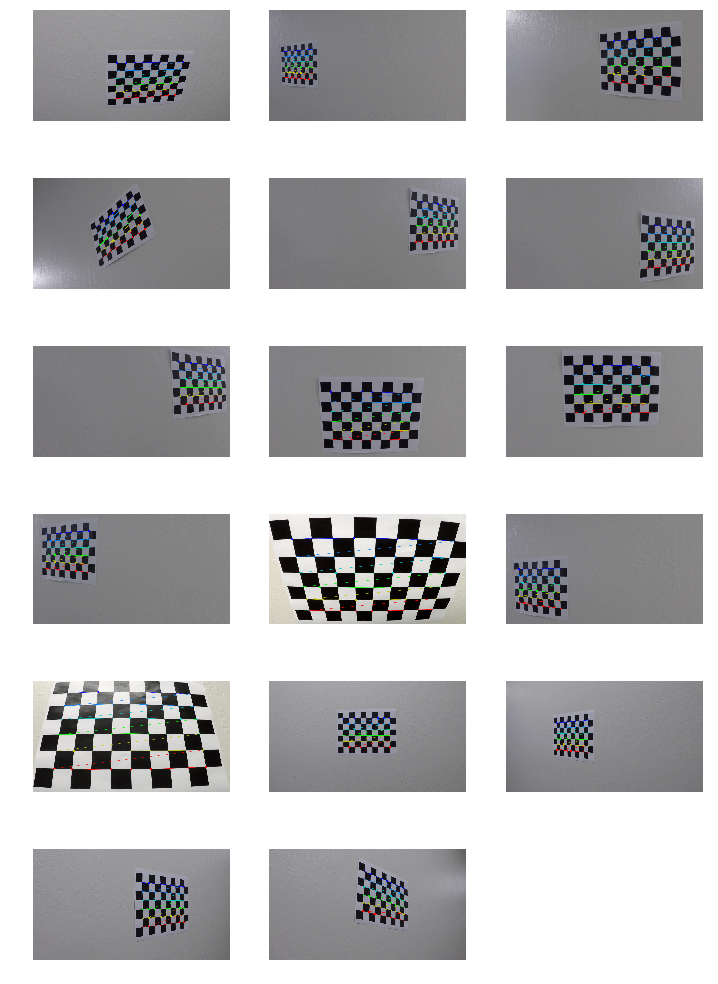


images of corners not detected


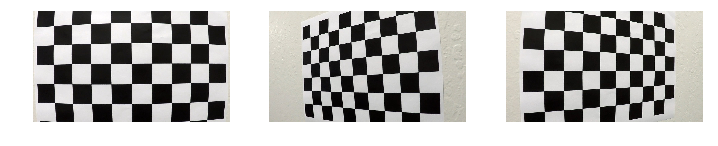

In [12]:
#Number of corners to be found
no_x = 9
no_y = 6

calib_imgs = read_calib_images()
points_3D, points_2D, corners_detected, corners_not_detected = find_corners(calib_imgs, no_x, no_y)

print("Number of images in which corners were detected = ", len(corners_detected))
print("Number of images in which corners were not detected = ", len(corners_not_detected))

# view the images
print("")
print("images of corners detected")
plt.figure(figsize=(12, 18))
for idx, img in enumerate(corners_detected):
    cv2.drawChessboardCorners(img, (no_x, no_y), points_2D[idx], True)
    plt.subplot(6, 3, idx+1)
    plt.imshow(img)
    plt.axis('off')    
plt.show()

print("")
print("images of corners not detected")
plt.figure(figsize=(12, 3))
for idx, img in enumerate(corners_not_detected):
    plt.subplot(1, 3, idx+1)
    plt.imshow(img)
    plt.axis('off')    
plt.show()



Since the number of x and y corners to be detected is more than the number of corners that could be observed in the previous 3 images, it is classified as not detected

Function to undistort an image

In [13]:
def get_calibration_value(img, points_3D, points_2D):
    
    img_shape = (img.shape[0], img.shape[1])
    
    #calibrate the camera
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(points_3D, points_2D, img_shape, None, None)
    return mtx, dist

def undistort_img(img, mtx, dist):
    return cv2.undistort(img, mtx, dist, None, mtx)

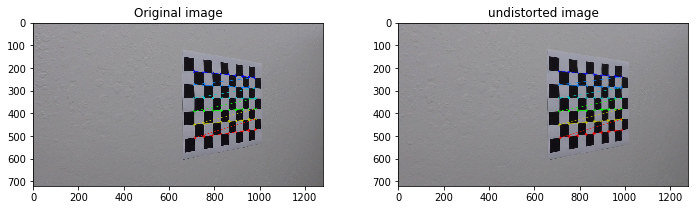

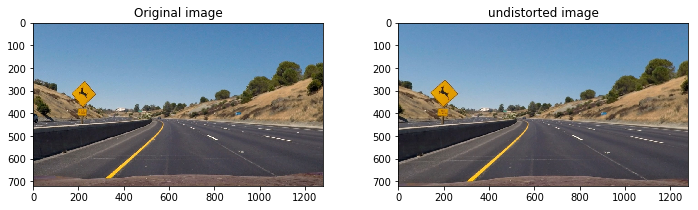

In [71]:
mtx, dist = get_calibration_value(corners_detected[0], points_3D, points_2D)

calibration_value = {}
calibration_value["mtx"] = mtx
calibration_value["dist"] = dist
pickle.dump( calibration_value, open( "calibration_value.p", "wb" ) )
img =corners_detected[15]
undist_img = undistort_img(img, mtx, dist)

plt.figure(figsize=(12, 3))
plt.subplot(1,2,1)
plt.title("Original image")
plt.imshow(img)
plt.subplot(1,2,2)
plt.title("undistorted image")
plt.imshow(undist_img)
plt.savefig("output_images/chessboard.png")
plt.show()

test_imgs = read_test_images()
test_img = test_imgs[3]
plt.figure(figsize=(12, 3))
plt.subplot(1,2,1)
plt.title("Original image")
plt.imshow(test_img)
plt.subplot(1,2,2)
plt.title("undistorted image")
plt.imshow(undistort_img(test_img, mtx, dist))
plt.savefig("output_images/road.png")
plt.show()

# Pipeline for lane detection
Convert the images to binary format

In [15]:
def convert_to_binary(img, sobel_thresh=(25,255), satu_thresh=(125, 255), light_thresh=(125,255)):
    
    raw_img = np.copy(img)
    
    # Convert to HLS color space and separate the H channel
    hls = cv2.cvtColor(raw_img, cv2.COLOR_RGB2HLS).astype(np.float)
    light_channel = hls[:,:,1]
    satu_channel = hls[:,:,2]
    
    # Sobel x
    sobel_x = cv2.Sobel(light_channel, cv2.CV_64F, 1, 0) 
    abs_sobel_x = np.absolute(sobel_x)
    scaled_sobel = np.uint8(255*abs_sobel_x/np.max(abs_sobel_x))
    
    # x gradient thresholding
    sx_binary = np.zeros_like(scaled_sobel)
    sx_binary[(scaled_sobel >= sobel_thresh[0]) & (scaled_sobel <= sobel_thresh[1])] = 1

    # Lightness channel thresholding
    light_binary = np.zeros_like(light_channel)
    light_binary[(light_channel >= light_thresh[0]) & (light_channel <= light_thresh[1])] = 1
    
    # Saturation channel thresholding
    satu_binary = np.zeros_like(satu_channel)
    satu_binary[(satu_channel >= satu_thresh[0]) & (satu_channel <= satu_thresh[1])] = 1
    
    binary = np.zeros_like(sx_binary)
    binary[((light_binary == 1) & (satu_binary == 1) | (sx_binary==1))] = 1
    binary = 255*np.dstack((binary,binary,binary)).astype('uint8')            
    return binary

Testing the binary functionality

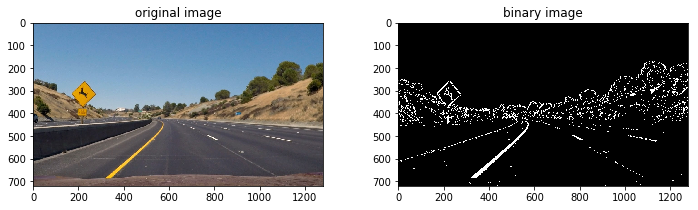

In [16]:

binary = convert_to_binary(test_img)
plt.figure(figsize=(12,3))
plt.subplot(1,2,1)
plt.title("original image")
plt.imshow(test_img)
plt.subplot(1,2,2)
plt.imshow(binary)
plt.title("binary image")
plt.savefig("output_images/thresholded_image.png")
plt.show()

Warping the images

In [83]:
# depending on the requirement of top view or camera view, warp the image
def img_warp(img, top_view=True):
    img_shape = (img.shape[1], img.shape[0])
    
    src = np.float32(
        [[200, 720],
         [585, 450],
         [700, 450],
         [1160, 720]])

    dst = np.float32(
        [[200,720],
         [200,0],
         [1080,0],
         [1080,720]])
    
    if top_view:
        M = cv2.getPerspectiveTransform(src, dst)
    else:
        M = cv2.getPerspectiveTransform(dst,src)
        
    warped_img = cv2.warpPerspective(img, M, img_shape, flags=cv2.INTER_LINEAR)
    
    return warped_img

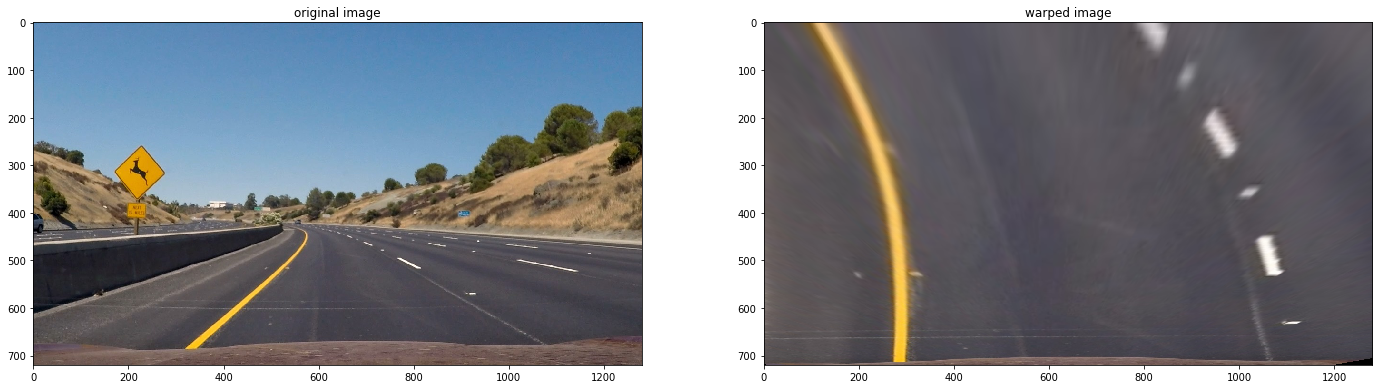

In [111]:

with open('calibration_value.p', mode='rb') as f:
    calibration_value = pickle.load(f)
    mtx = calibration_value["mtx"]
    dist = calibration_value["dist"]

test_img = test_imgs[3]
undist_img = undistort_img(test_img, mtx, dist)
warped_img = img_warp(undist_img)
plt.figure(figsize=(24,9))
plt.subplot(1,2,1)
plt.title("original image")
plt.imshow(test_img)
plt.subplot(1,2,2)
plt.imshow(warped_img)
plt.title("warped image")
plt.savefig("output_images/warped_image.png")
plt.show()

In [112]:
def img_msk(img):
    points = np.array([[(0,img.shape[0]),(585, 450), (700, 450), (img.shape[1],img.shape[0])]], dtype=np.int32)
    msk = np.zeros_like(img)
    
    no_of_channels = img.shape[2]
    msk_color = (255, ) * no_of_channels
    
    cv2.fillPoly(msk, points, msk_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, msk)
    return masked_image

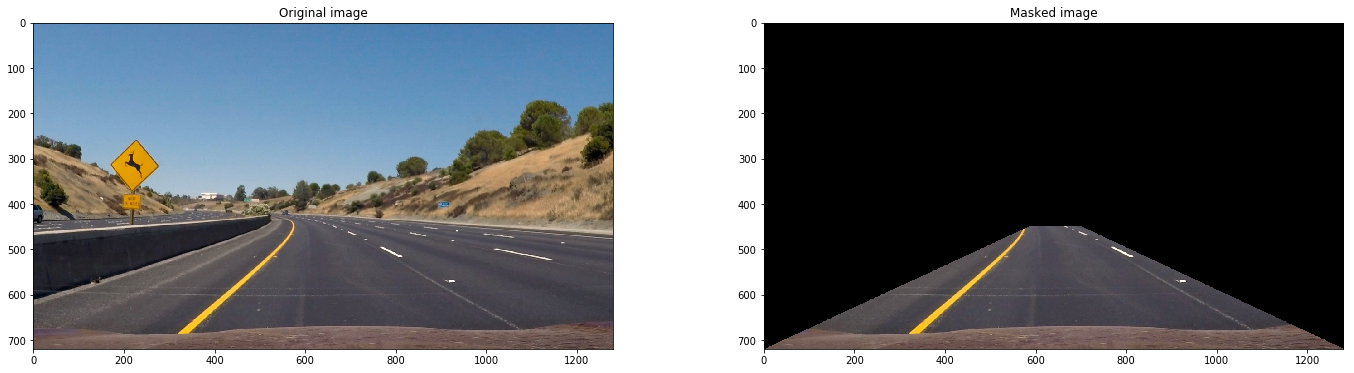

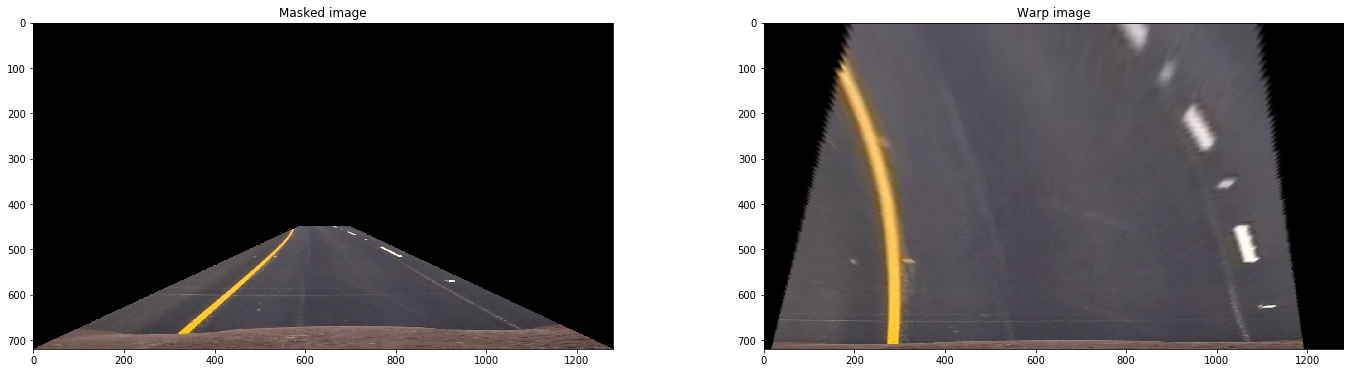

In [113]:
msk_img = img_msk(test_img)
warp_img = img_warp(msk_img)
plt.figure(figsize=(24,6))
plt.subplot(1,2,1)
plt.title("Original image")
plt.imshow(test_img)
plt.subplot(1,2,2)
plt.imshow(msk_img)
plt.title("Masked image")
plt.savefig("output_images/masked_image.png")
plt.show()

plt.figure(figsize=(24,6))
plt.subplot(1,2,1)
plt.imshow(msk_img)
plt.title("Masked image")
plt.subplot(1,2,2)
plt.imshow(warp_img)
plt.title("Warp image")
plt.savefig("output_images/mask_warp_image.png")
plt.show()


Pipeline functionality

In [114]:
def warp_pipe(img, mtx, dist):
    undist_img = undistort_img(img, mtx, dist)
    bin_img = convert_to_binary(undist_img)
    msked_img = img_msk(bin_img)
    warp_img = img_warp(msked_img)
    
    return warp_img

Testing the warp pipeline

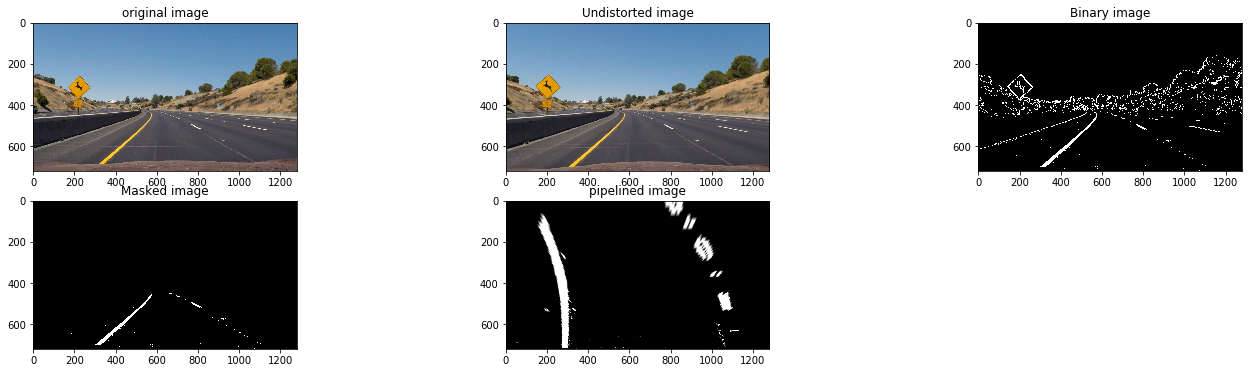

In [115]:
pipelined_img = warp_pipe(test_img, mtx, dist)
bin_img = convert_to_binary(undist_img)
msk_img = img_msk(bin_img)

plt.figure(figsize=(24,6))
plt.subplot(2,3,1)
plt.title("original image")
plt.imshow(test_img)
plt.subplot(2,3,2)
plt.title("Undistorted image")
plt.imshow(undist_img)
plt.subplot(2,3,3)
plt.title("Binary image")
plt.imshow(bin_img)
plt.subplot(2,3,4)
plt.title("Masked image")
plt.imshow(msk_img)
plt.subplot(2,3,5)
plt.title("pipelined image")
plt.imshow(pipelined_img)
plt.savefig("output_images/pipeline.png")
plt.show()

In [116]:
def histogram_peaks(img):
    mid_point = img[img.shape[0] // 2 :, :]
    histogram = np.sum(mid_point, axis=0)
    return histogram
    
def sliding_window(img):
    hist = histogram_peaks(img)
    
    mid = np.int(hist.shape[0] // 2)
    left_x_base = np.argmax(hist[:mid])
    right_x_base = np.argmax(hist[mid:]) + mid
    
    nwindows = 10
    window_height = np.int(img.shape[0]/nwindows)
    
    nonzero = img.nonzero()
    nonzero_y = np.array(nonzero[0])
    nonzero_x = np.array(nonzero[1])
   
    left_x_current = left_x_base
    right_x_current = right_x_base
    
    margin = 80
    minpix = 40
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = left_x_current - margin
        win_xleft_high = left_x_current + margin
        win_xright_low = right_x_current - margin
        win_xright_high = right_x_current + margin
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzero_y >= win_y_low) & (nonzero_y < win_y_high) & (nonzero_x >= win_xleft_low) & (nonzero_x < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzero_y >= win_y_low) & (nonzero_y < win_y_high) & (nonzero_x >= win_xright_low) & (nonzero_x < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            left_x_current = np.int(np.mean(nonzero_x[good_left_inds]))
        if len(good_right_inds) > minpix:        
            right_x_current = np.int(np.mean(nonzero_x[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzero_x[left_lane_inds]
    lefty = nonzero_y[left_lane_inds] 
    rightx = nonzero_x[right_lane_inds]
    righty = nonzero_y[right_lane_inds] 

    left_fit, right_fit = (None, None)
    # Fit a second order polynomial to each
    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit, (leftx, lefty), (rightx, righty)


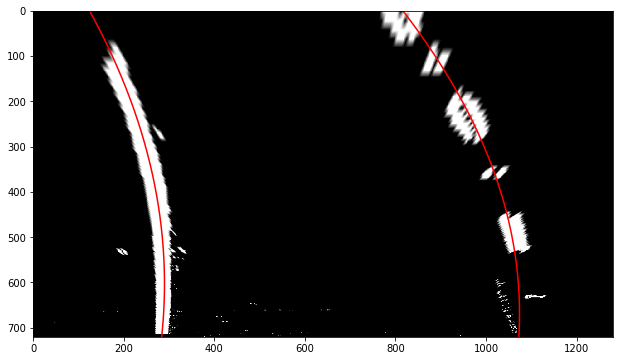

In [117]:
msk_bin_img = pipelined_img[:, :, 0]
plt.figure(figsize=(24,6))
left_fit, right_fit, left_ind, right_ind = sliding_window(msk_bin_img)
x = test_img.shape[0]

left_fit_x_int = left_fit[0]*x**2 + left_fit[1]*x + left_fit[2]
right_fit_x_int = right_fit[0]*x**2 + right_fit[1]*x + right_fit[2]

out_img = np.uint8(np.dstack((msk_bin_img, msk_bin_img, msk_bin_img))*255)
ploty = np.linspace(0, msk_bin_img.shape[0]-1, msk_bin_img.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
nonzero = msk_bin_img.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
plt.imshow(pipelined_img)
plt.plot(left_fitx, ploty, color='red')
plt.plot(right_fitx, ploty, color='red')
plt.xlim(0, 1280)
plt.ylim(720, 0)

plt.savefig("output_images/polyfit.png")
plt.show()

Draw lane onto the original image

In [118]:
def draw_lane(org_img, msk_bin_img, left_fit, right_fit):
    
    new_img = np.copy(org_img)
    # if there is no left and right fit then return the original image
    if left_fit is None or right_fit is None:
        return original_img
    
    # An image of the shape of original image to draw the lane and overlay on top of original image
    warp_zero = np.zeros_like(msk_bin_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    y,x = msk_bin_img.shape
    ploty = np.linspace(0, y-1, num=y)
    left_fit = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fit = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # stack x and y coodinates, which can be used in fill poly function
    pts_left = np.array([np.transpose(np.vstack([left_fit, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fit, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(0,255,0), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,0), thickness=15)

    # Warp the blank back to original image space
    inv_warp = img_warp(color_warp, top_view=False) 
    
    # Combine the lane image with the original image
    result = cv2.addWeighted(new_img, 1, inv_warp, 0.25, 0)
    return result, ploty
    

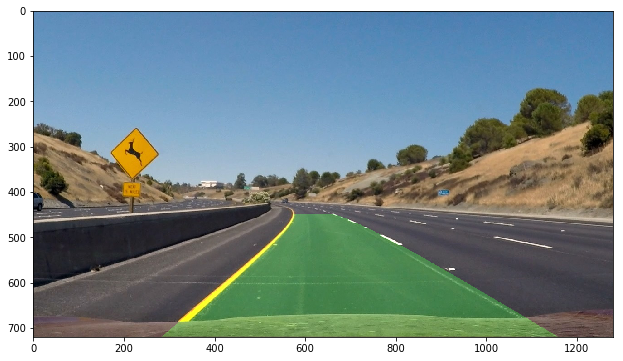

In [119]:
lane_img, ploty = draw_lane(test_img, msk_bin_img, left_fit, right_fit)
plt.figure(figsize=(12,6))
plt.imshow(lane_img)
plt.savefig("output_images/lane_image.png")
plt.show()

Calculation of Radius of curvature

In [120]:
def radius_of_curvature(ploty, left_lane_inds, right_lane_inds, img_shape):
    y_eval = np.max(ploty)

    # Define conversions in x and y from pixels space to meters
    y_met_per_pix = 30 / 720 # meters per pixel in y dimension
    x_met_per_pix = 3.7 / 700 # meters per pixel in x dimension

    # Extract left and right line pixel positions
    leftx = left_lane_inds[0]
    lefty = left_lane_inds[1] 
    rightx = right_lane_inds[0]
    righty = right_lane_inds[1]
    
    # Fit new polynomials to x,y in world space
    left_fit = np.polyfit(lefty * y_met_per_pix, leftx * x_met_per_pix, 2)
    right_fit = np.polyfit(righty * y_met_per_pix, rightx * x_met_per_pix, 2)
    
    # Calculate radius of curvature
    left_curve_radians = ((1 + (2 * left_fit[0] * y_eval * y_met_per_pix + left_fit[1]) ** 2) ** 1.5) \
                        / np.absolute(2 * left_fit[0])
    right_curve_radians = ((1 + (2 * right_fit[0] * y_eval * y_met_per_pix + right_fit[1]) ** 2) ** 1.5) \
                        / np.absolute(2 * right_fit[0])
    print(left_curve_radians, right_curve_radians)
    radius = round(np.mean([left_curve_radians, right_curve_radians]), 0) / 1000
    radius_text = "Radius of Curvature = {} km".format(round(radius, 4))
    
    # Calculating middle of the image, aka where the car camera is
    mid_img = img_shape[1] / 2
    car_pos = mid_img * x_met_per_pix
    
    # To calculate distance from center, Finds the base of the line at the bottom of the image.
    y = img_shape[0] * y_met_per_pix
    left_base_line = (left_fit[0] * y **2) + (left_fit[1] * y) + left_fit[2]
    right_base_line = (right_fit[0] * y **2) + (right_fit[1] * y) + right_fit[2]
    mid = (left_base_line + right_base_line) / 2
    dev_from_center = (mid - car_pos) * 100
    
    if dev_from_center >= 0:
        dev_text = "Car is {} cm left of center".format(round(dev_from_center, 4))
    else:
        dev_text = "Car is {} cm right of center".format(round(dev_from_center, 4))
        
    
    return radius_text, dev_text

360.779713466 284.722182121
Radius of Curvature = 0.323 km
Car is 20.1268 cm left of center


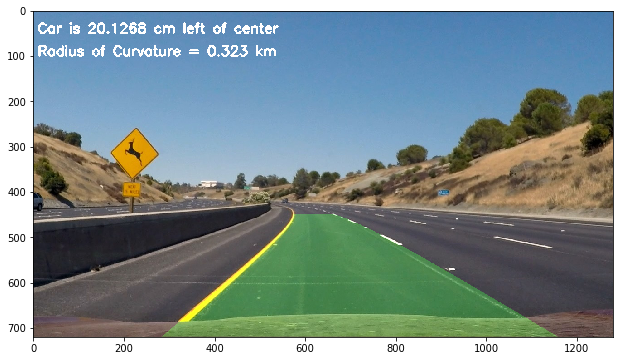

In [121]:
warp_img = warp_pipe(test_img, mtx, dist)
warp_bin_img = warp_img[:, :, 0]

l_fit, r_fit, l_lane_inds, r_lane_inds = sliding_window(warp_bin_img)

img_out, ploty = draw_lane(test_img, warp_bin_img, l_fit, r_fit)
rad, dev = radius_of_curvature(ploty, l_lane_inds, r_lane_inds, test_img.shape)
print(rad)
print(dev)
font = cv2.FONT_HERSHEY_SIMPLEX
cv2.putText(img_out, dev, (10,50), font, 1, (255,255,255), 3)
cv2.putText(img_out, rad, (10,100), font, 1, (255,255,255), 3)

plt.figure(figsize=(12,6))
plt.imshow(img_out)
plt.savefig("output_images/lane_radius_deviation_image.png")
plt.show()

In [122]:
def processing_pipeline(img):
    new_img = np.copy(img)
    warp_img = warp_pipe(new_img, mtx, dist)
    warp_bin_img = warp_img[:, :, 0]
    
    l_fit, r_fit, l_lane_inds, r_lane_inds = sliding_window(warp_bin_img)
    
    img_out, ploty = draw_lane(new_img, warp_bin_img, l_fit, r_fit)
    rad, dev = radius_of_curvature(ploty, l_lane_inds, r_lane_inds, new_img.shape)
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(img_out, dev, (10,50), font, 1, (255,255,255), 2)
    cv2.putText(img_out, rad, (10,100), font, 1, (255,255,255), 2)
    
    return img_out

In [109]:
from moviepy.editor import VideoFileClip
"""
left_line = Line()
right_line = Line()
"""
input_video = VideoFileClip('project_video.mp4')
processed_video = input_video.fl_image(processing_pipeline)

output_video = 'project_video_output.mp4'
%time processed_video.write_videofile(output_video, audio=False)

361.310788602 672.11461415
[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


  0%|          | 1/1261 [00:00<02:58,  7.07it/s]

361.310788602 672.11461415


  0%|          | 2/1261 [00:00<02:55,  7.16it/s]

357.524346082 498.5750693


  0%|          | 3/1261 [00:00<02:50,  7.37it/s]

344.415342031 517.355728131


  0%|          | 4/1261 [00:00<02:48,  7.47it/s]

339.299885224 596.064375949


  0%|          | 5/1261 [00:00<02:47,  7.48it/s]

344.626997244 601.234710259


  0%|          | 6/1261 [00:00<02:46,  7.53it/s]

349.242203615 457.251024444


  1%|          | 7/1261 [00:00<02:45,  7.59it/s]

378.260296425 430.912098477


  1%|          | 8/1261 [00:01<02:42,  7.70it/s]

381.052457077 517.818627448


  1%|          | 9/1261 [00:01<02:40,  7.78it/s]

420.317085415 986.438024639


  1%|          | 10/1261 [00:01<02:41,  7.75it/s]

426.388628815 739.298376175


  1%|          | 11/1261 [00:01<02:47,  7.48it/s]

440.014994098 667.982482828


  1%|          | 12/1261 [00:01<02:46,  7.51it/s]

504.107171964 591.136601041


  1%|          | 13/1261 [00:01<02:43,  7.61it/s]

503.058787222 932.915400517


  1%|          | 14/1261 [00:01<02:47,  7.47it/s]

522.488087564 889.594847825
508.028279923

  1%|▏         | 16/1261 [00:02<03:27,  6.01it/s]

 547.30298044
517.713502472 644.035263377


  1%|▏         | 17/1261 [00:02<03:32,  5.86it/s]

465.133987869 558.485242482


  1%|▏         | 18/1261 [00:02<03:32,  5.85it/s]

481.024692874 350.802342128


  2%|▏         | 20/1261 [00:03<03:50,  5.39it/s]

540.253600399 350.181501032
572.893225349 420.586929132


  2%|▏         | 21/1261 [00:03<03:56,  5.25it/s]

650.434317502 409.774380314
726.436978036 480.977977842

  2%|▏         | 24/1261 [00:03<03:24,  6.04it/s]


752.454372912 516.697597135
635.060767318 446.04190707


  2%|▏         | 26/1261 [00:03<02:59,  6.88it/s]

545.780393933 501.058130092
586.50911123 571.645983752


  2%|▏         | 28/1261 [00:04<02:57,  6.93it/s]

542.930158574 622.343540231
518.615770198 615.485881534


  2%|▏         | 30/1261 [00:04<02:49,  7.27it/s]

476.742545489 450.829499348
410.891073527 471.756536675


  3%|▎         | 32/1261 [00:04<02:41,  7.60it/s]

374.732912221 429.277111545
335.37942327 353.154694831


  3%|▎         | 34/1261 [00:04<02:36,  7.83it/s]

344.233855153 364.051631972
317.586521834 462.647041833


  3%|▎         | 36/1261 [00:05<02:33,  7.97it/s]

308.477687128 544.436109526
305.106593343 391.165169685


  3%|▎         | 38/1261 [00:05<02:31,  8.08it/s]

296.960427533 392.263549378
282.331312299 488.953465061


  3%|▎         | 40/1261 [00:05<02:33,  7.97it/s]

265.763233918 346.608231088
273.235773507 394.229762962


  3%|▎         | 42/1261 [00:05<02:31,  8.06it/s]

273.363114021 380.976636287
279.849632462 423.059003313


  3%|▎         | 44/1261 [00:06<02:43,  7.46it/s]

286.19162097 376.077124292
292.531867337 360.426045004


  4%|▎         | 46/1261 [00:06<02:40,  7.59it/s]

318.036896435 340.903082437
334.021369416 357.04123411


  4%|▍         | 48/1261 [00:06<02:35,  7.82it/s]

363.679291882 444.16355022
365.696030634 543.313098985


  4%|▍         | 50/1261 [00:07<02:31,  8.01it/s]

371.62468359 409.858541441
402.15879331 406.6555697


  4%|▍         | 51/1261 [00:07<02:35,  7.76it/s]

438.976766705 524.4891323


  4%|▍         | 52/1261 [00:07<03:24,  5.93it/s]

476.825177314 434.739418562


  4%|▍         | 54/1261 [00:07<03:56,  5.11it/s]

481.191146236 427.122122446
512.318150495 428.200712651


  4%|▍         | 56/1261 [00:08<03:18,  6.06it/s]

561.161884787 439.746842542
605.304972477 407.494171025


  5%|▍         | 58/1261 [00:08<03:12,  6.25it/s]

645.777704447 379.785909041
647.475952931 451.344953196


  5%|▍         | 60/1261 [00:08<03:07,  6.40it/s]

535.569939095 881.056543079
512.32784562 566.487140056


  5%|▍         | 62/1261 [00:09<02:58,  6.70it/s]

470.194992529 524.62041466
467.66129193 472.91857564


  5%|▌         | 64/1261 [00:09<03:00,  6.63it/s]

456.614414531 500.883315693
444.113209223 459.744758699


  5%|▌         | 66/1261 [00:09<02:52,  6.93it/s]

459.886712671 482.288617942
433.042440048 471.399793107


  5%|▌         | 68/1261 [00:09<02:51,  6.94it/s]

455.172876977 465.976706989
505.728462188 374.464115172


  6%|▌         | 70/1261 [00:10<02:46,  7.14it/s]

476.416675697 416.431531942
519.554148141 405.6455918


  6%|▌         | 72/1261 [00:10<02:39,  7.47it/s]

488.214101078 418.819934738
517.108048747 394.023948469


  6%|▌         | 74/1261 [00:10<02:33,  7.73it/s]

582.75701923 374.149593738
615.231520952 416.738527753


  6%|▌         | 76/1261 [00:10<02:30,  7.87it/s]

695.325898837 393.17807521
712.956631338 391.442519959


  6%|▌         | 78/1261 [00:11<02:32,  7.77it/s]

950.39240033 420.820545817
999.249297583 416.351485549


  6%|▋         | 80/1261 [00:11<02:35,  7.61it/s]

1130.11218556 435.234015605
1123.61141781 467.487685605


  7%|▋         | 82/1261 [00:11<02:46,  7.08it/s]

1045.84661519 430.719062357
1024.88698659 404.259134699


  7%|▋         | 84/1261 [00:12<02:57,  6.63it/s]

959.365634694 368.673701101
1279.83658258 360.859960788


  7%|▋         | 86/1261 [00:12<03:04,  6.35it/s]

1016.41299637 440.563346483
843.297291223 593.128157753


  7%|▋         | 88/1261 [00:12<03:06,  6.29it/s]

556.437370263 509.778117762
464.92181714 515.019005694


  7%|▋         | 90/1261 [00:13<03:14,  6.03it/s]

392.96080545 469.44005393
369.177195725 473.023248779


  7%|▋         | 92/1261 [00:13<03:08,  6.19it/s]

380.424036835 512.853852659
390.120268083 466.798163003


  7%|▋         | 94/1261 [00:13<03:25,  5.67it/s]

357.745114363 372.954432845
354.106546885 387.32004963


  8%|▊         | 96/1261 [00:14<03:13,  6.02it/s]

363.01614175 406.515181813
369.467444197 450.616888657


  8%|▊         | 98/1261 [00:14<03:06,  6.24it/s]

387.388528321 431.986121104
400.149951626 428.410448867


  8%|▊         | 100/1261 [00:14<02:54,  6.66it/s]

411.705140036 424.340283649
401.025361766 429.495226802


  8%|▊         | 102/1261 [00:14<02:42,  7.14it/s]

406.061019866 410.315024896
395.934403321 381.999501926


  8%|▊         | 104/1261 [00:15<02:33,  7.55it/s]

398.162118273 421.165586739
383.671817565 378.888711528


  8%|▊         | 106/1261 [00:15<02:31,  7.63it/s]

407.834818113 416.329098983
407.840126149 402.198387789


  9%|▊         | 108/1261 [00:15<02:29,  7.73it/s]

416.364972551 453.543968523
389.531633359 312.184209175


  9%|▊         | 110/1261 [00:16<02:31,  7.58it/s]

385.709969055 351.751832498
381.692846639 440.472948707


  9%|▉         | 112/1261 [00:16<02:53,  6.62it/s]

373.586724779 372.062056945
396.486941999 366.727037283


  9%|▉         | 114/1261 [00:16<02:52,  6.66it/s]

358.402985781 343.565244766
372.867919344 411.466922787


  9%|▉         | 116/1261 [00:16<02:55,  6.54it/s]

339.69833269 341.59198608
336.094619986 360.214310226


  9%|▉         | 118/1261 [00:17<02:56,  6.47it/s]

331.908796023 372.696193349
329.035822538 373.461092832


 10%|▉         | 120/1261 [00:17<02:49,  6.71it/s]

325.809729308 303.211553378
313.670842368 341.650224407


 10%|▉         | 122/1261 [00:17<02:38,  7.19it/s]

310.075473156 370.07149399
306.614980764 413.665737132


 10%|▉         | 124/1261 [00:18<02:35,  7.33it/s]

295.612812012 366.88651681
299.470455464 364.588608115


 10%|▉         | 126/1261 [00:18<02:28,  7.64it/s]

313.951677327 343.252664048
331.351558083 378.940569244


 10%|█         | 128/1261 [00:18<02:22,  7.96it/s]

320.733569957 383.444055817
336.147171182 376.023142413


 10%|█         | 130/1261 [00:18<02:20,  8.08it/s]

329.516175506 350.367999178
334.996311319 344.680353106


 10%|█         | 132/1261 [00:19<02:17,  8.21it/s]

341.566302374 362.398333202
338.051013959 390.683326382


 11%|█         | 134/1261 [00:19<02:18,  8.15it/s]

357.637604822 395.055037337
365.404740129 500.830481568


 11%|█         | 136/1261 [00:19<02:17,  8.21it/s]

388.03615894 485.760763788
405.070143831 448.436059473


 11%|█         | 138/1261 [00:19<02:21,  7.94it/s]

423.793326994 485.686630918
456.08996611 469.136528666


 11%|█         | 140/1261 [00:20<02:22,  7.84it/s]

485.296880732 556.907508997
480.921427691 542.240842859


 11%|█▏        | 142/1261 [00:20<02:24,  7.74it/s]

500.104921122 530.082026871
520.402318657 468.829599553


 11%|█▏        | 144/1261 [00:20<02:23,  7.80it/s]

478.72979339 445.569622554
484.712058938 374.812463751


 12%|█▏        | 146/1261 [00:20<02:22,  7.83it/s]

492.180700914 400.20794797
454.355299964 461.409411329


 12%|█▏        | 148/1261 [00:21<02:22,  7.80it/s]

490.253639592 512.526448766
423.924473551 449.97697653


 12%|█▏        | 150/1261 [00:21<02:21,  7.85it/s]

417.197114356 441.8459071
449.903816537 432.264412196


 12%|█▏        | 152/1261 [00:21<02:21,  7.84it/s]

451.78651551 392.698262026
486.020456537 443.980424192


 12%|█▏        | 154/1261 [00:21<02:20,  7.86it/s]

449.507755861 478.239131298
493.613169393 517.522077554


 12%|█▏        | 156/1261 [00:22<02:22,  7.76it/s]

483.100641252 507.783745849
490.306998732 415.529844678


 13%|█▎        | 158/1261 [00:22<02:20,  7.87it/s]

465.840315229 408.207374477
424.633466623 484.653779341


 13%|█▎        | 160/1261 [00:22<02:20,  7.82it/s]

427.383499262 538.08908932
405.394020756 482.607115177


 13%|█▎        | 162/1261 [00:22<02:19,  7.90it/s]

418.67393796 517.50973198
424.432824691 549.558386398


 13%|█▎        | 164/1261 [00:23<02:21,  7.77it/s]

436.251885728 504.39282334
425.401167568 451.458529984


 13%|█▎        | 166/1261 [00:23<02:19,  7.84it/s]

390.913276587 416.374959801
408.919242495 433.14263102


 13%|█▎        | 168/1261 [00:23<02:18,  7.88it/s]

393.153538989 367.692586035
446.162362237 326.250009698


 13%|█▎        | 170/1261 [00:23<02:17,  7.92it/s]

464.334871145 304.416966076
519.831474573 283.279514621


 14%|█▎        | 172/1261 [00:24<02:17,  7.92it/s]

545.386483613 274.9667898
513.591566255 292.543384257


 14%|█▍        | 174/1261 [00:24<02:17,  7.93it/s]

514.392741643 249.327903637
467.238265229 245.040757569


 14%|█▍        | 176/1261 [00:24<02:16,  7.95it/s]

442.576774193 262.532652464
455.686562528 249.70446169


 14%|█▍        | 178/1261 [00:24<02:17,  7.90it/s]

493.140208511 256.547786963
489.40481955 259.7854449


 14%|█▍        | 180/1261 [00:25<02:16,  7.92it/s]

467.308174316 258.376710626
456.682943293 294.707428429


 14%|█▍        | 182/1261 [00:25<02:17,  7.87it/s]

381.820763095 266.467499961
378.140845116 293.855835984


 15%|█▍        | 184/1261 [00:25<02:16,  7.89it/s]

331.387595778 309.343417924
299.854439139 364.181633383


 15%|█▍        | 186/1261 [00:25<02:15,  7.90it/s]

289.978424226 381.809144712
250.334304566 297.607640918


 15%|█▍        | 188/1261 [00:26<02:14,  7.98it/s]

249.93554428 353.198987436
244.05772625 373.076534871


 15%|█▌        | 190/1261 [00:26<02:13,  8.04it/s]

249.67495141 320.948027662
261.055218534 284.994634299


 15%|█▌        | 192/1261 [00:26<02:14,  7.93it/s]

256.7059375 333.897806438
273.16553196 329.92898526


 15%|█▌        | 194/1261 [00:26<02:12,  8.06it/s]

277.859884315 325.436145856
288.494944721 253.257893586


 16%|█▌        | 196/1261 [00:27<02:13,  7.98it/s]

290.590010731 323.150055928
346.627994093 409.280204451


 16%|█▌        | 198/1261 [00:27<02:13,  7.96it/s]

402.283525025 549.810227511
453.828477038 489.105060879


 16%|█▌        | 200/1261 [00:27<02:13,  7.93it/s]

532.419815756 464.041213385
562.103725535 411.430905926


 16%|█▌        | 202/1261 [00:27<02:16,  7.77it/s]

548.354702638 385.574849143
485.945848773 501.000183518


 16%|█▌        | 204/1261 [00:28<02:15,  7.82it/s]

427.655391716 389.072862827
464.407280219 395.803884039


 16%|█▋        | 206/1261 [00:28<02:14,  7.85it/s]

426.233389681 342.725678153
418.941893774 333.57998173


 16%|█▋        | 208/1261 [00:28<02:14,  7.84it/s]

369.475177917 404.220217687
346.589849424 466.489163451


 17%|█▋        | 210/1261 [00:28<02:12,  7.93it/s]

345.060195339 461.236352622
379.381899871 435.886840565


 17%|█▋        | 212/1261 [00:29<02:12,  7.92it/s]

397.125305356 428.340315811
357.684201723 467.922581835


 17%|█▋        | 214/1261 [00:29<02:11,  7.96it/s]

355.779414724 610.133155002
318.24704952 490.729731802


 17%|█▋        | 216/1261 [00:29<02:11,  7.93it/s]

317.953882043 528.108875672
314.350186451 449.394849619


 17%|█▋        | 218/1261 [00:29<02:10,  7.96it/s]

320.830055444 577.843891101
350.698668403 496.952766161


 17%|█▋        | 220/1261 [00:30<02:09,  8.02it/s]

339.683344835 424.554585571
372.038230411 440.61639822


 18%|█▊        | 222/1261 [00:30<02:08,  8.08it/s]

400.589602264 543.793556224
426.840505166 564.709903282


 18%|█▊        | 224/1261 [00:30<02:07,  8.11it/s]

453.967866408 470.440125568
428.450033211 458.231337439


 18%|█▊        | 226/1261 [00:30<02:06,  8.17it/s]

439.118515247 581.200525462
446.296845188 458.470489329


 18%|█▊        | 228/1261 [00:31<02:06,  8.20it/s]

475.531101675 457.078700774
526.899955863 436.796128248


 18%|█▊        | 230/1261 [00:31<02:05,  8.22it/s]

533.239085602 445.548117922
534.124341582 405.056878144


 18%|█▊        | 232/1261 [00:31<02:05,  8.21it/s]

554.949667963 338.798866951
641.115890661 332.245514611


 19%|█▊        | 234/1261 [00:31<02:04,  8.24it/s]

677.313404621 352.460434722
717.257577184 422.432347848


 19%|█▊        | 236/1261 [00:32<02:04,  8.23it/s]

719.231351911 345.642777629
663.312533514 328.180329341


 19%|█▉        | 238/1261 [00:32<02:05,  8.16it/s]

639.739708917 341.46602909
597.823521 278.851889223


 19%|█▉        | 240/1261 [00:32<02:04,  8.20it/s]

580.0928581 315.966106013
555.431507269 310.98412603


 19%|█▉        | 242/1261 [00:32<02:02,  8.29it/s]

499.979611969 317.490852117
553.888212377 314.299789609


 19%|█▉        | 244/1261 [00:33<02:02,  8.28it/s]

481.611745313 322.434168015
518.576204632 350.040287395


 20%|█▉        | 246/1261 [00:33<02:03,  8.23it/s]

476.791329323 352.875287473
450.458758167 348.938678606


 20%|█▉        | 248/1261 [00:33<02:04,  8.17it/s]

447.920372692 339.279027283
405.60879444 280.30996708


 20%|█▉        | 250/1261 [00:33<02:03,  8.17it/s]

436.595944382 320.065536535
428.936376152 360.778703121


 20%|█▉        | 252/1261 [00:34<02:03,  8.17it/s]

457.762950746 352.936953138
480.995362016 338.841516884


 20%|██        | 254/1261 [00:34<02:02,  8.20it/s]

477.427906215 336.971422415
525.806199594 319.325426188


 20%|██        | 256/1261 [00:34<02:04,  8.04it/s]

514.281244515 326.798802478
520.019610868 365.386600001


 20%|██        | 258/1261 [00:34<02:02,  8.15it/s]

507.192607854 332.415530188
525.098518657 318.851143749


 21%|██        | 260/1261 [00:35<02:03,  8.10it/s]

536.326009436 327.34385303
500.423059623 283.306626601


 21%|██        | 262/1261 [00:35<02:02,  8.15it/s]

570.77021298 328.399173244
564.373368601 353.417416952


 21%|██        | 264/1261 [00:35<02:02,  8.15it/s]

562.196988512 373.887324735
546.581941517 365.359870274


 21%|██        | 266/1261 [00:35<02:01,  8.16it/s]

526.049321818 348.892258836
548.047294279 371.112190268


 21%|██▏       | 268/1261 [00:36<02:02,  8.09it/s]

498.061650347 386.400753818
492.493490058 402.828091595


 21%|██▏       | 270/1261 [00:36<02:01,  8.13it/s]

544.151471053 422.320576757
514.910707454 451.387463771


 22%|██▏       | 272/1261 [00:36<02:01,  8.11it/s]

515.914578664 490.375650576
472.316977197 412.173483564


 22%|██▏       | 274/1261 [00:36<02:01,  8.10it/s]

512.4448445 419.250384762
482.674756317 422.579420399


 22%|██▏       | 276/1261 [00:37<02:02,  8.02it/s]

511.383309125 456.568024618
585.251655031 480.532914177


 22%|██▏       | 278/1261 [00:37<02:02,  8.04it/s]

620.681891736 434.572354067
660.467957096 424.734986155


 22%|██▏       | 280/1261 [00:37<02:02,  8.04it/s]

686.17156874 465.45808741
681.884283066 498.78196966


 22%|██▏       | 282/1261 [00:37<02:01,  8.07it/s]

684.312706535 539.793862515
694.64282183 481.130213513


 23%|██▎       | 284/1261 [00:38<02:02,  7.99it/s]

744.559447521 472.416949613
713.260232079 456.020498951


 23%|██▎       | 286/1261 [00:38<02:12,  7.36it/s]

778.921047047 502.626607467
850.780491966 524.4239667


 23%|██▎       | 288/1261 [00:38<02:08,  7.58it/s]

793.077389143 539.653127592
839.89523431 540.791750402


 23%|██▎       | 290/1261 [00:38<02:05,  7.75it/s]

754.917333055 477.991403173
774.961497536 447.990823437


 23%|██▎       | 292/1261 [00:39<02:04,  7.79it/s]

716.757524999 514.582335752
720.659717647 587.015571224


 23%|██▎       | 294/1261 [00:39<02:10,  7.39it/s]

721.491757811 592.314710183
759.304160429 547.162243431


 23%|██▎       | 296/1261 [00:39<02:18,  6.98it/s]

771.579161668 574.011302844
809.67125832 619.805301403


 24%|██▎       | 298/1261 [00:40<02:34,  6.23it/s]

837.697076112 728.818163575
912.876586688 665.169997254


 24%|██▍       | 300/1261 [00:40<02:30,  6.40it/s]

986.470890561 672.743610138
980.19386343 698.175576262


 24%|██▍       | 302/1261 [00:40<02:35,  6.17it/s]

1109.26981792 755.4032642
1136.05161763 718.256928692


 24%|██▍       | 304/1261 [00:41<02:28,  6.47it/s]

1231.56002428 800.702845323
1331.57272119 1173.53260222


 24%|██▍       | 306/1261 [00:41<02:18,  6.88it/s]

1415.0537205 3001.0439959
1773.47942951 6753.86790187


 24%|██▍       | 308/1261 [00:41<02:16,  6.99it/s]

1851.62888999 255031.612819
2410.77810303 4727.33492978


 25%|██▍       | 310/1261 [00:41<02:13,  7.10it/s]

2696.59979744 1979.44406556
3845.36989381 1018.35506181


 25%|██▍       | 312/1261 [00:42<02:33,  6.17it/s]

8944.41774053 1120.94406004
6225.11373498 1604.84646238


 25%|██▍       | 314/1261 [00:42<02:42,  5.82it/s]

13177.301247 1436.55734346
19473.4784674 1349.17021827


 25%|██▌       | 316/1261 [00:42<02:49,  5.58it/s]

30858.8985822 1125.87874592
9752.9190951 1139.92787767


 25%|██▌       | 318/1261 [00:43<02:46,  5.68it/s]

35667.5080178 790.099309802
11244.0974347 578.700043859


 25%|██▌       | 319/1261 [00:43<02:44,  5.74it/s]

7437.46297811 717.674655056
16521.6944119

 25%|██▌       | 321/1261 [00:43<02:58,  5.25it/s]

 715.321934754
5498.67946512 905.416539457


 26%|██▌       | 323/1261 [00:44<02:58,  5.26it/s]

3723.653071 837.082369268
3967.72667756 893.341499842


 26%|██▌       | 325/1261 [00:44<02:40,  5.84it/s]

4285.36334326 919.783267931
3467.94168193 1109.09142367


 26%|██▌       | 327/1261 [00:44<02:29,  6.27it/s]

3601.22575582 1665.05930216
4660.87160597 1667.24738976


 26%|██▌       | 328/1261 [00:45<02:33,  6.06it/s]

4786.855824 1805.5040261


 26%|██▌       | 329/1261 [00:45<02:49,  5.50it/s]

5961.85975623 3234.10606136


 26%|██▌       | 330/1261 [00:45<03:03,  5.08it/s]

5145.75143931 25162.467801
3731.39867727 

 26%|██▋       | 332/1261 [00:45<03:09,  4.91it/s]

2726.66355784
4005.18008853 1214.16332732


 26%|██▋       | 333/1261 [00:46<03:14,  4.77it/s]

5478.102237 1427.36080804


 26%|██▋       | 334/1261 [00:46<03:14,  4.77it/s]

5331.3782651 1719.43101447
6503.0301177

 27%|██▋       | 337/1261 [00:46<02:57,  5.22it/s]

 2826.69729661
6156.86552393 1570.22952946
5468.30801334 1809.26995731


 27%|██▋       | 339/1261 [00:47<02:56,  5.21it/s]

5749.8502716 2632.58117214
11517.9768976 4014.78316021


 27%|██▋       | 341/1261 [00:47<02:43,  5.63it/s]

9573.73767102 21453.9763306
42296.3261988 17024.9596188


 27%|██▋       | 343/1261 [00:48<02:48,  5.45it/s]

134926.412133 1090.19468625
11146.5785699 998.955940408


 27%|██▋       | 344/1261 [00:48<02:49,  5.41it/s]

6869.43759246 1096.71008499


 27%|██▋       | 346/1261 [00:48<03:05,  4.94it/s]

4692.9017542 1296.65587423
5169.30442833 1294.59930293


 28%|██▊       | 348/1261 [00:49<02:52,  5.30it/s]

9627.94088582 1290.25399358
6504.9200499 1474.95395323


 28%|██▊       | 350/1261 [00:49<02:54,  5.23it/s]

11835.6935309 1645.06729077
4865.49807056 1481.61565144


 28%|██▊       | 352/1261 [00:49<02:44,  5.53it/s]

6123.56868167 1906.27979661
8815.39016008 2027.65110687


 28%|██▊       | 354/1261 [00:50<02:49,  5.34it/s]

5757.51639066 1703.8605324
9764.83816088 2486.71612183


 28%|██▊       | 356/1261 [00:50<02:40,  5.65it/s]

25518.1329331 7186.73753086
15694.9430702 3038.98180711


 28%|██▊       | 358/1261 [00:50<02:45,  5.46it/s]

2461.88343398 1354.25646705
2182.66860393 1079.34986416


 29%|██▊       | 360/1261 [00:51<02:43,  5.52it/s]

1376.68631517 1467.39265728
1229.22045455 1372.84574485


 29%|██▊       | 361/1261 [00:51<02:44,  5.46it/s]

1002.61566713 1424.20458957
920.658092792 2495.74498886


 29%|██▉       | 364/1261 [00:51<02:41,  5.57it/s]

836.29819278 3559.26085625
949.836638101 2532.02312756


 29%|██▉       | 366/1261 [00:52<02:35,  5.75it/s]

882.41985746 7011.81432926
879.031385918 7141.00768832


 29%|██▉       | 368/1261 [00:52<02:32,  5.87it/s]

862.97343087 15327.1120772
887.107014843 6948.51318814


 29%|██▉       | 370/1261 [00:52<02:32,  5.85it/s]

993.033161243 1853.55760344
1071.60111594 2699.8670784


 30%|██▉       | 372/1261 [00:53<02:31,  5.88it/s]

1206.76499183 2749.58632271
1347.75217418 2566.90386892


 30%|██▉       | 374/1261 [00:53<02:31,  5.87it/s]

1664.44737 3057.17798377
2321.8612771 15658.4349442


 30%|██▉       | 376/1261 [00:53<02:27,  6.02it/s]

4601.5077646 113540.701296
89988.0743552 43396.6075756


 30%|██▉       | 378/1261 [00:54<02:28,  5.97it/s]

8122.53970855 2748.40163671
3627.56098609 22365.6250871


 30%|███       | 380/1261 [00:54<02:26,  6.01it/s]

3112.9557015 159881.182482
2408.9169287 11337.054338


 30%|███       | 382/1261 [00:54<02:26,  5.99it/s]

2965.06085496 5941.23338831
2010.50184816 38768.533625


 30%|███       | 384/1261 [00:55<02:27,  5.94it/s]

2261.2514306 32530.1432458
2243.34009646 6239.26223065


 31%|███       | 386/1261 [00:55<02:26,  5.99it/s]

2232.11463111 4210.43779912
2433.03578239 4413.73703596


 31%|███       | 388/1261 [00:55<02:27,  5.93it/s]

2167.3383843 3419.32531831
2728.12629762 4194.53803933


 31%|███       | 390/1261 [00:56<02:25,  5.99it/s]

2671.65748092 4867.04057564
2721.75326655 2543.96960772


 31%|███       | 392/1261 [00:56<02:24,  6.01it/s]

2221.68499031 5233.08290973
2152.73851337 2864.85949879


 31%|███       | 394/1261 [00:56<02:23,  6.04it/s]

2996.21977742 1218.29188019
3065.1035878 1047.41302788


 31%|███▏      | 396/1261 [00:57<02:21,  6.10it/s]

3791.44030176 1501.62590853
7737.40454473 2088.00838067


 32%|███▏      | 398/1261 [00:57<02:22,  6.07it/s]

8914.31564505 2858.12694786
14329.8410979 2112.12413789


 32%|███▏      | 400/1261 [00:57<02:22,  6.03it/s]

6834.88784584 2225.0599263
6768.14350378 19107.2967698


 32%|███▏      | 402/1261 [00:58<02:23,  5.99it/s]

18654.979753 2489.2943201
42021.5737769 1785.0403748


 32%|███▏      | 404/1261 [00:58<02:27,  5.81it/s]

19535.6944827 4910.85309439
25073.8855732 5612.43552205


 32%|███▏      | 406/1261 [00:58<02:24,  5.93it/s]

45188.2953952 6110.21091077
16893.3839252 2902.19105481


 32%|███▏      | 408/1261 [00:59<02:22,  5.97it/s]

12689.4077443 1674.42688967
13663.0209657 2856.86059576


 33%|███▎      | 410/1261 [00:59<02:21,  6.01it/s]

8354.8090978 4448.52285919
13512.3763184 2303.67144981


 33%|███▎      | 412/1261 [00:59<02:21,  5.99it/s]

12458.4131746 37502.8196379
6799.78236886 5740.22210108


 33%|███▎      | 414/1261 [01:00<02:26,  5.79it/s]

3888.03535302 2501.83179699
3179.63881953 3352.90927592


 33%|███▎      | 416/1261 [01:00<02:30,  5.62it/s]

2734.73940677 12250.8551173
2209.04971938 13945.0321766


 33%|███▎      | 417/1261 [01:00<02:27,  5.72it/s]

2733.31729014 2311.31969446


 33%|███▎      | 418/1261 [01:01<02:36,  5.39it/s]

2472.49250579 1352.76749576
2381.45744536 

 33%|███▎      | 420/1261 [01:01<02:44,  5.11it/s]

3576.01528136
2293.69732347 4669.91689517


 33%|███▎      | 421/1261 [01:01<02:54,  4.81it/s]

2735.88453697 2623.13184625


 33%|███▎      | 422/1261 [01:01<02:56,  4.76it/s]

2949.30115115 4973.70556608


 34%|███▎      | 423/1261 [01:02<02:58,  4.70it/s]

2652.64560899 2325.67329295


 34%|███▎      | 424/1261 [01:02<03:00,  4.63it/s]

3310.01141501 2620.07890209


 34%|███▎      | 425/1261 [01:02<03:01,  4.60it/s]

3693.24006871 2278.18051611


 34%|███▍      | 426/1261 [01:02<03:00,  4.62it/s]

4780.29764273 1561.72197297


 34%|███▍      | 427/1261 [01:03<03:01,  4.61it/s]

6122.58512315 2601.10955474


 34%|███▍      | 428/1261 [01:03<03:03,  4.54it/s]

16066.2234373 16832.4186009


 34%|███▍      | 429/1261 [01:03<02:59,  4.62it/s]

7524.45189278 4643.53186911


 34%|███▍      | 430/1261 [01:03<02:57,  4.67it/s]

8246.96852371 8504.9994986


 34%|███▍      | 431/1261 [01:03<02:58,  4.64it/s]

4872.20160573 1021421.76176


 34%|███▍      | 432/1261 [01:04<02:58,  4.64it/s]

2727.16086605 4321.55124248


 34%|███▍      | 434/1261 [01:04<02:47,  4.94it/s]

3081.70931879 5413.85866926
2268.31070805 3942.09245505


 35%|███▍      | 436/1261 [01:04<02:34,  5.35it/s]

1813.88223598 2272.10197911
1862.12238616 1272.45134257


 35%|███▍      | 438/1261 [01:05<02:19,  5.90it/s]

1544.99306476 1999.47287105
1526.55962604 1780.69862848


 35%|███▍      | 440/1261 [01:05<02:04,  6.62it/s]

1418.26222221 3091.60396482
1473.83334787 1345.27528952


 35%|███▌      | 442/1261 [01:05<02:11,  6.25it/s]

1599.40514362 2407.35788236
1658.06379596 1828.38057253


 35%|███▌      | 443/1261 [01:05<02:15,  6.05it/s]

1385.6602894 2275.06107247


 35%|███▌      | 445/1261 [01:06<02:38,  5.13it/s]

1456.14520855 2306.27564754
1344.98009216 2885.44463924


 35%|███▌      | 447/1261 [01:06<02:35,  5.22it/s]

1633.78021408 1377.90731986
1665.15665024 1535.29258416


 36%|███▌      | 449/1261 [01:07<02:32,  5.33it/s]

2026.38027492 1714.19300785
2624.31638919 3977.14681234


 36%|███▌      | 451/1261 [01:07<02:32,  5.30it/s]

3590.74986146 3572.56308779
5755.84520148 5747.00181221


 36%|███▌      | 453/1261 [01:07<02:29,  5.39it/s]

18075.5269719 54205.074485
77347.059446 9015.72758666


 36%|███▌      | 454/1261 [01:08<02:29,  5.39it/s]

5053.81386576 17307.193948
4354.51113535

 36%|███▌      | 457/1261 [01:08<02:34,  5.21it/s]

 11022.2899596
2908.60456081 21923.42066
3168.46487708 5415.1668727


 36%|███▋      | 458/1261 [01:08<02:41,  4.98it/s]

3183.61169518 7762.64838336


 36%|███▋      | 459/1261 [01:09<02:49,  4.74it/s]

2632.62235554 9588.01615523


 36%|███▋      | 460/1261 [01:09<02:51,  4.67it/s]

2279.85834354 3928.5683874


 37%|███▋      | 462/1261 [01:09<02:45,  4.83it/s]

2702.0326105 1268.24420588
2463.37271268 2062.27448836


 37%|███▋      | 463/1261 [01:09<02:52,  4.61it/s]

1985.44662914 1379.73937493


 37%|███▋      | 464/1261 [01:10<03:06,  4.27it/s]

2025.78925789 1013.69092627


 37%|███▋      | 465/1261 [01:10<03:14,  4.08it/s]

2162.87385471 1140.78330446


 37%|███▋      | 467/1261 [01:10<02:53,  4.57it/s]

2377.66633527 1305.13731502
3500.64129969 2065.4106402


 37%|███▋      | 469/1261 [01:11<02:37,  5.02it/s]

5018.15596787 2107.02652055
5559.29532842 5595.45680699


 37%|███▋      | 471/1261 [01:11<02:21,  5.58it/s]

4716.55690002 2316.65968144
8128.71253578 8257.48856142


 38%|███▊      | 473/1261 [01:11<02:13,  5.89it/s]

19876.0904742 36965.6778319
130297.380032 3455.96730502


 38%|███▊      | 475/1261 [01:12<02:12,  5.95it/s]

14661.5072438 13729.5330861
21733.1699071 6704.49204514


 38%|███▊      | 477/1261 [01:12<02:04,  6.31it/s]

9403.66646126 5248.97411842
7712.31023677 6782.69456791


 38%|███▊      | 479/1261 [01:12<02:06,  6.17it/s]

5258.89876451 2998.68406333
2691.24345636 2542.57648898


 38%|███▊      | 481/1261 [01:13<02:08,  6.08it/s]

3067.0153898 9105.04978765
3500.6195449 13268.5526237


 38%|███▊      | 483/1261 [01:13<02:09,  6.00it/s]

3305.62787203 13600.5399806
3972.08730533 60768.2096018


 38%|███▊      | 485/1261 [01:13<02:09,  6.01it/s]

7481.06458323 3540.68898066
5236.40489519 1255.69952953


 39%|███▊      | 487/1261 [01:14<02:23,  5.40it/s]

4500.84630095 1222.41179585
4570.57583079 1734.08910239


 39%|███▊      | 488/1261 [01:14<02:29,  5.18it/s]

15506.0513751 32444.515256


 39%|███▉      | 489/1261 [01:14<02:35,  4.97it/s]

115839.178115 12639.989393


 39%|███▉      | 491/1261 [01:15<02:36,  4.91it/s]

147516.389697 3874.57980685
7421.11219247 3930.46918432


 39%|███▉      | 493/1261 [01:15<02:28,  5.18it/s]

36699.2870423 65043.2278853
30275.5827615 4321.33419754


 39%|███▉      | 494/1261 [01:15<02:26,  5.24it/s]

12658.0908282 23134.4105479


 39%|███▉      | 495/1261 [01:15<02:34,  4.96it/s]

25986.2692576 3870.73515221


 39%|███▉      | 497/1261 [01:16<02:30,  5.06it/s]

32907.6147689 1474.30437441
64033.5482292 1443.19403761


 40%|███▉      | 499/1261 [01:16<02:24,  5.26it/s]

97095.170976 4181.75358228
13182.9811874 5913.01987976


 40%|███▉      | 501/1261 [01:17<02:17,  5.54it/s]

4324.45167806 2909.06162112
7019.59126175 6647.39859805


 40%|███▉      | 503/1261 [01:17<02:01,  6.26it/s]

8082.17874741 13342.7076479
6883.77043558 2876.57720185


 40%|████      | 505/1261 [01:17<02:04,  6.09it/s]

10006.0997459 3197.58684473
20042.4729368 12482.5216797


 40%|████      | 507/1261 [01:18<02:08,  5.85it/s]

32810.813603 6042.50610428
21791.7431777 41035.3819432


 40%|████      | 509/1261 [01:18<01:57,  6.37it/s]

9398.48701384 7031.29221219
8108.83852888 2542.29895524


 41%|████      | 511/1261 [01:18<01:53,  6.62it/s]

32469.7716727 1069.64165441
35630.040348 861.452010342


 41%|████      | 513/1261 [01:18<01:52,  6.64it/s]

7528.88273214 1248.20681066
7760.43942183 2695.98636265


 41%|████      | 515/1261 [01:19<02:00,  6.21it/s]

3753.87349219 12719.0520943
7005.14760325 8819.99436861


 41%|████      | 517/1261 [01:19<01:56,  6.38it/s]

5507.66532369 8623.43783996
7040.44842455 9273.88085626


 41%|████      | 519/1261 [01:19<01:57,  6.33it/s]

6057.28366135 2484.63371777
6263.39352365 2529.42808676


 41%|████▏     | 521/1261 [01:20<01:56,  6.37it/s]

5589.64327735 4074.32200565
11091.6145294 1555.60851987


 41%|████▏     | 523/1261 [01:20<01:52,  6.55it/s]

5989.48054251 12040.3238628
3759.07966296 33300.4342436


 42%|████▏     | 525/1261 [01:20<01:51,  6.58it/s]

7339.60693431 83705.4707233
4039.81771868 17077.3392495


 42%|████▏     | 527/1261 [01:21<01:52,  6.51it/s]

4260.68552249 7730.7065019
3914.74746764 3358.0266446


 42%|████▏     | 529/1261 [01:21<01:52,  6.52it/s]

4567.68811013 7296.81432121
3595.41947071 2487.35912604


 42%|████▏     | 531/1261 [01:21<01:45,  6.89it/s]

2765.07849005 3294.13626972
2383.52981571 20479.7217608


 42%|████▏     | 533/1261 [01:21<01:38,  7.36it/s]

3582.84957816 8570.61269809
1607.59077681 5987.06043783


 42%|████▏     | 535/1261 [01:22<01:37,  7.44it/s]

1341.80593313 4358.56428199
2053.33139312 9832.87070394


 43%|████▎     | 537/1261 [01:22<01:38,  7.37it/s]

3029.19555622 22104.121389
3481.48403647 14869.7593068


 43%|████▎     | 539/1261 [01:22<01:38,  7.33it/s]

13860.0559253 28484.8765434
5530.74104265 5068.1343262


 43%|████▎     | 541/1261 [01:23<01:40,  7.19it/s]

4605.6257059 2758.74485353
5714.41288091 2043.71278559


 43%|████▎     | 543/1261 [01:23<01:49,  6.55it/s]

4741.26558209 13119.3053879
11015.9071145 242631.262891


 43%|████▎     | 545/1261 [01:23<01:57,  6.11it/s]

4223.39144499 4137.64753598
2873.56210685 2100.20639532


 43%|████▎     | 547/1261 [01:24<01:59,  5.98it/s]

2979.81622346 893.299636258
2496.19900895 816.754646301


 44%|████▎     | 549/1261 [01:24<01:57,  6.05it/s]

2924.20286026 744.534469093
1622.23166823 723.145396147


 44%|████▎     | 551/1261 [01:24<01:47,  6.60it/s]

1627.71817948 1449.08014014
1697.15478288 1260.10226498


 44%|████▍     | 553/1261 [01:24<01:41,  6.95it/s]

2033.35529595 1371.10642509
1406.64761815 1274.16889993


 44%|████▍     | 555/1261 [01:25<01:34,  7.44it/s]

1301.40692207 1769.26305752
1425.35093037 1785.46054094


 44%|████▍     | 557/1261 [01:25<01:34,  7.42it/s]

1302.63995101 1260.14926098
1220.95025254 1644.42574449


 44%|████▍     | 559/1261 [01:25<01:36,  7.30it/s]

999.765140952 2140.49480519
1270.87702513 846.275078168


 44%|████▍     | 561/1261 [01:25<01:33,  7.49it/s]

1609.28772544 392.591879952
1883.11571045 365.305222753


 45%|████▍     | 563/1261 [01:26<01:31,  7.62it/s]

1641.86561257 297.305715646
1461.53062661 865.334466707


 45%|████▍     | 565/1261 [01:26<01:29,  7.77it/s]

1296.66204694 8099.75008019
906.034073609 590.180795945


 45%|████▍     | 567/1261 [01:26<01:26,  8.06it/s]

2182.23325278 1239.33254127
2746.19157497 1082.22725135


 45%|████▌     | 569/1261 [01:26<01:24,  8.15it/s]

2773.00350675 1003.2763563
7677.0268147 967.26904242


 45%|████▌     | 571/1261 [01:27<01:25,  8.11it/s]

31788.2953481 943.547753384
7922.29971408 1479.11224107


 45%|████▌     | 573/1261 [01:27<01:23,  8.21it/s]

4133.33043035 1441.62724722
2961.860597 1682.14378239


 46%|████▌     | 575/1261 [01:27<01:23,  8.26it/s]

1989.56364891 1600.00668331
4625.86647532 1368.90969588


 46%|████▌     | 577/1261 [01:27<01:22,  8.28it/s]

17642.645882 1564.7300157
1276.44596313 12774.6759856


 46%|████▌     | 579/1261 [01:28<01:22,  8.27it/s]

723.431845497 1584.61480881
2500.25288028 888.162924349


 46%|████▌     | 581/1261 [01:28<01:22,  8.22it/s]

2501.15275523 1037.45815954
1939.37787701 774.601302503


 46%|████▌     | 583/1261 [01:28<01:22,  8.24it/s]

3263.79570026 967.456983342
42113.6803813 1041.23397163


 46%|████▋     | 585/1261 [01:28<01:21,  8.27it/s]

579.327233155 877.194290243
587.417737129 806.020719805


 47%|████▋     | 587/1261 [01:29<01:21,  8.30it/s]

526.979083469 862.930222992
529.808447481 907.172330469


 47%|████▋     | 589/1261 [01:29<01:22,  8.16it/s]

953.828299581 818.83622263
539.316387059 783.260829598


 47%|████▋     | 591/1261 [01:29<01:22,  8.11it/s]

2091.84833617 1205.13278323
1441.41809624 1000.68134709


 47%|████▋     | 593/1261 [01:29<01:22,  8.07it/s]

2479.14124369 1114.474014
2947.31170539 1135.48258229


 47%|████▋     | 595/1261 [01:30<01:23,  7.97it/s]

7556.31376542 2352.28744402
6558.51857651 2013.87474227


 47%|████▋     | 597/1261 [01:30<01:22,  8.07it/s]

8862.25034586 6072.68101977
12635.2724788 4407.13916439


 48%|████▊     | 599/1261 [01:30<01:21,  8.12it/s]

5140.92770222 4347.56056264
4418.2400933 3978.06475475


 48%|████▊     | 601/1261 [01:30<01:20,  8.19it/s]

842.865410911 2078.62390486
1054.11135537 3048.60914959


 48%|████▊     | 603/1261 [01:31<01:20,  8.21it/s]

608.783832862 1510.66896617
551.852784501 1374.9824643


 48%|████▊     | 605/1261 [01:31<01:19,  8.20it/s]

505.973894525 2763.82465876
444.340576528 832.228202836


 48%|████▊     | 607/1261 [01:31<01:20,  8.14it/s]

377.078819365 495.47121906
375.148617989 398.03563619


 48%|████▊     | 609/1261 [01:31<01:21,  8.01it/s]

346.839057828 434.457494228
355.356332345 470.414354682


 48%|████▊     | 611/1261 [01:32<01:22,  7.92it/s]

384.303583246 482.899056782
352.962663535 449.385127215


 49%|████▊     | 613/1261 [01:32<01:21,  7.91it/s]

370.777985422 401.144082017
353.829316379 380.381595835


 49%|████▉     | 615/1261 [01:32<01:22,  7.82it/s]

319.09055933 306.256676172
319.11812461 267.765048081


 49%|████▉     | 617/1261 [01:32<01:22,  7.84it/s]

327.601246523 394.277221745
324.202761578 1433.87855026


 49%|████▉     | 619/1261 [01:33<01:22,  7.76it/s]

330.190080995 2116.97125077
306.395360435 838.895046497


 49%|████▉     | 621/1261 [01:33<01:23,  7.69it/s]

332.358892443 1037.11006315
348.11032505 874.999626324


 49%|████▉     | 623/1261 [01:33<01:22,  7.71it/s]

364.48808104 1886.56535301
383.504594815 6733.27407549


 50%|████▉     | 625/1261 [01:33<01:22,  7.75it/s]

377.344479174 2518.14776085
324.94884569 675.866508689


 50%|████▉     | 627/1261 [01:34<01:20,  7.86it/s]

324.474323259 700.80546179
335.486749052 768.543043189


 50%|████▉     | 629/1261 [01:34<01:19,  7.93it/s]

345.737384721 584.656887772
389.47010581 396.953748744


 50%|█████     | 631/1261 [01:34<01:25,  7.41it/s]

512.669181082 2681.25133005
569.98186092 1231.69095508


 50%|█████     | 633/1261 [01:34<01:24,  7.44it/s]

632.619652562 948.813630857
703.451887699 798.454608238


 50%|█████     | 635/1261 [01:35<01:24,  7.43it/s]

649.462845967 6846.66147367
653.601939726 797.208623503


 51%|█████     | 637/1261 [01:35<01:22,  7.53it/s]

583.072994416 666.971807107
512.385664766 340.268973166


 51%|█████     | 639/1261 [01:35<01:23,  7.48it/s]

523.213517262 347.741738665
580.827055282 416.572601078


 51%|█████     | 641/1261 [01:36<01:29,  6.90it/s]

753.734481391 797.757574809
848.13533905 1674.84537308


 51%|█████     | 643/1261 [01:36<01:26,  7.15it/s]

879.359842044 2505.50942028
908.470075056 3233.26255845


 51%|█████     | 645/1261 [01:36<01:26,  7.11it/s]

833.622753874 1427.91030504
767.041952729 898.881611944


 51%|█████▏    | 647/1261 [01:36<01:23,  7.35it/s]

629.429942536 381.344305042
559.921216105 675.615814471


 51%|█████▏    | 649/1261 [01:37<01:21,  7.52it/s]

556.857618515 504.3558328
580.964217394 458.845360956


 52%|█████▏    | 651/1261 [01:37<01:20,  7.53it/s]

558.698337561 461.483513915
520.081788745 889.373616399


 52%|█████▏    | 653/1261 [01:37<01:18,  7.73it/s]

506.728191502 920.516958947
484.958348341 762.752889457


 52%|█████▏    | 655/1261 [01:37<01:18,  7.74it/s]

470.196482997 1069.45118478
433.561058016 754.637377665


 52%|█████▏    | 657/1261 [01:38<01:18,  7.65it/s]

455.060241755 633.507706783
427.36411676 528.651987847


 52%|█████▏    | 659/1261 [01:38<01:19,  7.54it/s]

412.200275212 860.451661534
415.891734388 1098.38870652


 52%|█████▏    | 661/1261 [01:38<01:19,  7.54it/s]

448.244053549 968.616088806
457.759400534 924.426371956


 53%|█████▎    | 663/1261 [01:39<01:17,  7.67it/s]

462.439018764 904.77038445
473.26437686 1814.90837821


 53%|█████▎    | 665/1261 [01:39<01:17,  7.73it/s]

488.773167105 2451.42135382
494.648398795 1752.13357227


 53%|█████▎    | 667/1261 [01:39<01:16,  7.78it/s]

517.006613325 1190.46725162
528.237565633 954.941521206


 53%|█████▎    | 669/1261 [01:39<01:15,  7.82it/s]

559.360405465 1188.49815018
610.829946499 864.655458337


 53%|█████▎    | 671/1261 [01:40<01:16,  7.71it/s]

622.629513298 800.069237764
640.392691474 1462.17392377


 53%|█████▎    | 673/1261 [01:40<01:16,  7.70it/s]

638.407955293 845.358225035
698.403788594 1036.18958475


 54%|█████▎    | 675/1261 [01:40<01:16,  7.63it/s]

708.702216856 2180.15108711
654.107290148 1892.08015437


 54%|█████▎    | 677/1261 [01:40<01:17,  7.50it/s]

698.002120632 1179.14453205
650.777095947 1078.18089604


 54%|█████▍    | 679/1261 [01:41<01:16,  7.58it/s]

693.906062613 996.245076717
643.800778627 812.502860965


 54%|█████▍    | 681/1261 [01:41<01:15,  7.64it/s]

653.490681844 653.562246947
574.040187947 833.421329562


 54%|█████▍    | 683/1261 [01:41<01:15,  7.66it/s]

590.697002791 688.388858832
549.288571067 532.520591646


 54%|█████▍    | 685/1261 [01:41<01:15,  7.59it/s]

576.396005015 711.209484624
584.729098626 653.714897695


 54%|█████▍    | 687/1261 [01:42<01:16,  7.49it/s]

524.753455703 1182.59155558
483.03728445 1136.20823016


 55%|█████▍    | 689/1261 [01:42<01:18,  7.28it/s]

479.620794315 1263.17881307
477.999751545 1539.60935942


 55%|█████▍    | 691/1261 [01:42<01:16,  7.42it/s]

465.360958496 1097.88060678
432.430897089 1095.30662278


 55%|█████▍    | 693/1261 [01:42<01:16,  7.43it/s]

424.338774806 848.941028593
415.50137703 778.280155101


 55%|█████▌    | 695/1261 [01:43<01:15,  7.47it/s]

440.057779072 859.452771951
412.351480158 944.139052478


 55%|█████▌    | 697/1261 [01:43<01:16,  7.34it/s]

417.218572581 1014.82923493
433.627287593 1309.60036001


 55%|█████▌    | 699/1261 [01:43<01:15,  7.47it/s]

416.272801484 1183.52875835
414.726189995 927.471415205


 56%|█████▌    | 701/1261 [01:44<01:17,  7.19it/s]

390.529356303 653.400216942
407.24625129 540.744764771


 56%|█████▌    | 703/1261 [01:44<01:19,  7.00it/s]

413.342154506 570.322100033
426.609358567 569.262532442


 56%|█████▌    | 705/1261 [01:44<01:20,  6.95it/s]

472.06076996 517.02530372
450.936113081 553.959751569


 56%|█████▌    | 707/1261 [01:44<01:22,  6.70it/s]

476.47061278 804.033227909
469.512600443 724.823287713


 56%|█████▌    | 709/1261 [01:45<01:20,  6.85it/s]

476.476939397 654.009825341
484.797681174 643.557103839


 56%|█████▋    | 711/1261 [01:45<01:19,  6.88it/s]

498.334816484 604.131542536
489.949787689 604.27584852


 57%|█████▋    | 713/1261 [01:45<01:18,  6.99it/s]

489.476660104 600.453391801
489.265597165 622.646236666


 57%|█████▋    | 715/1261 [01:46<01:17,  7.05it/s]

484.660159269 523.864390407
471.120035114 449.471617619


 57%|█████▋    | 717/1261 [01:46<01:17,  7.05it/s]

464.694643671 516.377770713
494.540912867 414.39916929


 57%|█████▋    | 719/1261 [01:46<01:16,  7.08it/s]

501.865765604 465.955328247
535.449443338 447.731455908


 57%|█████▋    | 721/1261 [01:46<01:17,  6.96it/s]

495.521283635 576.581980794
480.539488842 709.329958313


 57%|█████▋    | 723/1261 [01:47<01:16,  7.06it/s]

498.472475078 741.331795945
520.103313188 644.62282068


 57%|█████▋    | 725/1261 [01:47<01:16,  7.00it/s]

505.885249626 616.090250117
499.158870323 636.277427389


 58%|█████▊    | 727/1261 [01:47<01:16,  6.98it/s]

454.606407827 772.864261034
458.899721036 1337.2734482


 58%|█████▊    | 729/1261 [01:48<01:14,  7.11it/s]

441.834251864 9863.45958897
451.902397325 1295.96125328


 58%|█████▊    | 731/1261 [01:48<01:14,  7.12it/s]

449.540758075 2733.98651224
457.756628219 15447.0305681


 58%|█████▊    | 733/1261 [01:48<01:14,  7.09it/s]

436.30473928 1699.50112612
439.105987498 676.097120344


 58%|█████▊    | 735/1261 [01:48<01:12,  7.27it/s]

472.877225898 1028.96178917
459.89506618 1249.52194328


 58%|█████▊    | 737/1261 [01:49<01:10,  7.41it/s]

431.591237106 762.812817156
442.109851641 830.894883148


 59%|█████▊    | 739/1261 [01:49<01:09,  7.50it/s]

430.408361102 1306.49273035
447.725795801 1413.03918337


 59%|█████▉    | 741/1261 [01:49<01:08,  7.59it/s]

459.083473653 4792.54708784
483.956512446 10533.2409931


 59%|█████▉    | 743/1261 [01:49<01:08,  7.52it/s]

494.356644891 1081.76884303
500.214586294 827.642674525


 59%|█████▉    | 745/1261 [01:50<01:08,  7.57it/s]

505.745624108 578.027884727
531.200895233 498.031236822


 59%|█████▉    | 747/1261 [01:50<01:07,  7.65it/s]

549.672762992 443.496141708
531.987559335 424.46806474


 59%|█████▉    | 749/1261 [01:50<01:06,  7.66it/s]

557.04857437 429.64533429
539.737263502 483.045755338


 60%|█████▉    | 751/1261 [01:51<01:08,  7.46it/s]

613.533737721 638.143302573
546.319097549 491.635965284


 60%|█████▉    | 753/1261 [01:51<01:07,  7.47it/s]

576.358471684 1300.22252812
582.1805336 2452.96791992


 60%|█████▉    | 755/1261 [01:51<01:07,  7.51it/s]

498.559874662 15832.7291447
501.668199846 6459.5177102


 60%|██████    | 757/1261 [01:51<01:07,  7.49it/s]

516.322041394 3917.97247856
506.321953143 1597.42308369


 60%|██████    | 759/1261 [01:52<01:10,  7.15it/s]

500.55990861 1540.43440101
506.180616086 667.146536105


 60%|██████    | 761/1261 [01:52<01:12,  6.94it/s]

473.538456044 884.0406291
442.162100248 963.982543588


 61%|██████    | 763/1261 [01:52<01:09,  7.20it/s]

447.968826439 3790.844331
448.130695516 1773.43454097


 61%|██████    | 765/1261 [01:52<01:09,  7.12it/s]

409.707231576 332.958705563
417.863366561 256.96088503


 61%|██████    | 767/1261 [01:53<01:08,  7.24it/s]

414.033351159 2225.73684535
407.554476804 3239.02969531


 61%|██████    | 769/1261 [01:53<01:08,  7.19it/s]

419.406059993 8157.70990053
400.44087643 433.618191145


 61%|██████    | 771/1261 [01:53<01:08,  7.18it/s]

412.101689515 454.237657693
430.44188733 490.053114356


 61%|██████▏   | 773/1261 [01:54<01:08,  7.09it/s]

434.41461153 499.148537051
444.664935001 517.677855197


 61%|██████▏   | 775/1261 [01:54<01:07,  7.18it/s]

454.989558001 1227.03319608
450.57860298 1642.38607115


 62%|██████▏   | 777/1261 [01:54<01:06,  7.24it/s]

446.364262254 587.974510407
469.281094438 5749.3901778


 62%|██████▏   | 779/1261 [01:54<01:06,  7.21it/s]

464.576038958 1004.40045198
486.17046164 1145.32831142


 62%|██████▏   | 781/1261 [01:55<01:14,  6.45it/s]

498.838719912 1080.67447618
564.632205964 2100.50869332


 62%|██████▏   | 783/1261 [01:55<01:19,  5.98it/s]

595.75546248 1809.77533177
596.543571398 2938.51336156


 62%|██████▏   | 785/1261 [01:55<01:17,  6.17it/s]

578.149353199 3415.08007767
566.749268947 7089.71168926


 62%|██████▏   | 787/1261 [01:56<01:11,  6.63it/s]

600.340783136 925.834331619
630.107818586 1719.79845458


 63%|██████▎   | 789/1261 [01:56<01:07,  7.00it/s]

645.305214464 11105.470149
640.202299057 1714.29659023


 63%|██████▎   | 791/1261 [01:56<01:04,  7.34it/s]

658.827384882 5723.0496131
677.928351946 22410.9721903


 63%|██████▎   | 793/1261 [01:57<01:03,  7.40it/s]

760.789274803 1174.51051008
762.670786953 2261.67047168


 63%|██████▎   | 795/1261 [01:57<01:01,  7.57it/s]

807.459112551 2123.29783718
740.369681053 1288.44378031


 63%|██████▎   | 797/1261 [01:57<01:01,  7.53it/s]

716.307119458 2222.45823471
688.464714496 4619.38096488


 63%|██████▎   | 799/1261 [01:57<01:00,  7.67it/s]

685.708725666 7754.14514641
677.983972162 59786.7580086


 64%|██████▎   | 801/1261 [01:58<01:00,  7.61it/s]

722.737990401 1647.05109277
715.799654367 2608.35410106


 64%|██████▎   | 803/1261 [01:58<01:00,  7.59it/s]

751.511862811 2065.00291625
701.288242068 2684.27575598


 64%|██████▍   | 805/1261 [01:58<01:02,  7.27it/s]

570.044407825 1806.85373461
512.262640466 1861.93675232


 64%|██████▍   | 807/1261 [01:58<01:03,  7.18it/s]

479.892737744 4946.96690876
484.749874635 4053.53918128


 64%|██████▍   | 809/1261 [01:59<01:04,  6.97it/s]

420.263608154 3768.41373022
436.736820906 51024.3550393


 64%|██████▍   | 811/1261 [01:59<01:07,  6.70it/s]

427.79068319 7143.81653304
434.742875475 8603.45351941


 64%|██████▍   | 813/1261 [01:59<01:07,  6.64it/s]

447.89555548 4479.31238456
464.523488631 11029.8847791


 65%|██████▍   | 815/1261 [02:00<01:05,  6.84it/s]

477.763636799 2110.57089017
485.058762374 1346.29645001


 65%|██████▍   | 817/1261 [02:00<01:04,  6.85it/s]

503.876721378 773.89038422
472.362089926 570.522996707


 65%|██████▍   | 819/1261 [02:00<01:02,  7.03it/s]

472.290337272 498.290081564
484.474616218 526.701953599


 65%|██████▌   | 821/1261 [02:00<01:02,  7.04it/s]

505.814319984 549.144491415
502.464102572 556.326508699


 65%|██████▌   | 823/1261 [02:01<01:03,  6.86it/s]

556.117826595 650.354356229
573.882010184 881.002011935


 65%|██████▌   | 825/1261 [02:01<01:02,  6.95it/s]

596.342136274 841.102467322
609.344433927 568.879477717


 66%|██████▌   | 827/1261 [02:01<01:07,  6.43it/s]

588.050755533 637.961275012
545.64068257 567.480773869


 66%|██████▌   | 829/1261 [02:02<01:02,  6.87it/s]

560.468135819 530.344382203
569.584065189 635.429639919


 66%|██████▌   | 831/1261 [02:02<01:01,  7.00it/s]

498.899357698 595.958240663
488.312630322 667.099604562


 66%|██████▌   | 833/1261 [02:02<01:01,  6.97it/s]

446.044979945 748.230984081
443.716623873 605.219165947


 66%|██████▌   | 835/1261 [02:02<01:03,  6.72it/s]

430.189849934 765.123140314
430.159928238 943.476077003


 66%|██████▋   | 837/1261 [02:03<01:02,  6.79it/s]

434.57851118 1515.72188591
421.426353438 1524.85969747


 67%|██████▋   | 839/1261 [02:03<00:59,  7.15it/s]

418.216729547 997.216908478
416.617893994 533.885529635


 67%|██████▋   | 841/1261 [02:03<00:58,  7.19it/s]

405.089764561 612.07072002
426.575121323 647.26035753


 67%|██████▋   | 843/1261 [02:04<00:56,  7.39it/s]

418.348049646 661.694427573
427.687669124 633.188154716


 67%|██████▋   | 845/1261 [02:04<00:57,  7.23it/s]

441.859638663 791.638058281
456.9273619 538.827416412


 67%|██████▋   | 847/1261 [02:04<00:59,  6.96it/s]

469.254403986 1066.63347157
504.428295175 71965.0811152


 67%|██████▋   | 849/1261 [02:05<01:08,  5.98it/s]

522.76948378 4060.35975027
574.953218648 2980.45034153


 67%|██████▋   | 851/1261 [02:05<01:10,  5.84it/s]

564.721048047 5723.5701514
633.097435248 1954.89692081


 68%|██████▊   | 853/1261 [02:05<01:09,  5.86it/s]

707.035284762 3928.24578699
685.504636679 2730.81481204


 68%|██████▊   | 855/1261 [02:06<01:05,  6.17it/s]

723.730215275 1383.02364865
693.025574442 1042.69963871


 68%|██████▊   | 857/1261 [02:06<01:01,  6.53it/s]

714.451078358 1849.04490051
750.560191128 4594.74244602


 68%|██████▊   | 859/1261 [02:06<00:58,  6.85it/s]

717.697470139 957.637556924
702.302264176 2260.43981352


 68%|██████▊   | 861/1261 [02:06<00:56,  7.11it/s]

717.221981626 4053.80269292
742.179557433 4552.71973443


 68%|██████▊   | 863/1261 [02:07<00:56,  7.09it/s]

705.318426339 2116.34230459
708.24211489 9232.26379468


 69%|██████▊   | 865/1261 [02:07<00:56,  6.96it/s]

731.533918862 1239.98772124
719.236464471 1059.21179156


 69%|██████▉   | 867/1261 [02:07<00:58,  6.75it/s]

737.499306986 508.913657552
740.411364434 519.526622624


 69%|██████▉   | 869/1261 [02:08<00:56,  6.90it/s]

717.693017961 280.590384612
675.826958358 748.809466715


 69%|██████▉   | 871/1261 [02:08<00:55,  6.99it/s]

717.352559362 878.336627675
632.015416861 9968.7594562


 69%|██████▉   | 873/1261 [02:08<00:52,  7.41it/s]

638.459070873 1022.58042531
651.750708973 952.739158656


 69%|██████▉   | 875/1261 [02:08<00:50,  7.58it/s]

639.922712135 5837.69242171
588.000227558 603.278650575


 70%|██████▉   | 877/1261 [02:09<00:49,  7.71it/s]

560.066525772 5368.9278389
519.518531708 2509.33229141


 70%|██████▉   | 879/1261 [02:09<00:50,  7.53it/s]

553.490744037 39918.6606646
600.219071167 1594.10694259


 70%|██████▉   | 881/1261 [02:09<00:52,  7.29it/s]

556.981546617 723.587857841
577.117927304 452.51490913


 70%|███████   | 883/1261 [02:09<00:52,  7.19it/s]

651.137658054 4415.10475567
636.645886255 940.463351549


 70%|███████   | 885/1261 [02:10<00:51,  7.25it/s]

727.487509578 814.745044257
761.035877868 834.486670916


 70%|███████   | 887/1261 [02:10<00:49,  7.49it/s]

809.537788878 1628.76367388
992.53192126 959.450181146


 70%|███████   | 889/1261 [02:10<00:50,  7.34it/s]

1002.74702974 1566.31741097
1044.9744565 575.880484216


 71%|███████   | 891/1261 [02:11<00:49,  7.44it/s]

1038.94732497 645.935317191
1161.62451 980.626362241


 71%|███████   | 893/1261 [02:11<00:49,  7.46it/s]

1111.31215259 1294.37339376
1047.24518525 1395.3598762


 71%|███████   | 895/1261 [02:11<00:50,  7.29it/s]

1043.94041355 1636.2909761
1128.03702497 1234.6876567


 71%|███████   | 897/1261 [02:11<00:48,  7.46it/s]

979.513926071 1497.189097
950.671493918 1217.64784499


 71%|███████▏  | 899/1261 [02:12<00:50,  7.19it/s]

977.762066962 466.435265895
985.68160693 561.21180272


 71%|███████▏  | 901/1261 [02:12<00:50,  7.16it/s]

926.000157844 2659.0214778
849.371708946 3226.08025814


 72%|███████▏  | 903/1261 [02:12<00:48,  7.33it/s]

883.268303531 87539.5511009
814.71095606 30310.3258487


 72%|███████▏  | 905/1261 [02:12<00:47,  7.46it/s]

731.685673281 13058.4828081
717.520125744 2553.28360488


 72%|███████▏  | 907/1261 [02:13<00:47,  7.50it/s]

684.39992935 2798.01382266
685.363953121 9467.76488163


 72%|███████▏  | 909/1261 [02:13<00:46,  7.56it/s]

576.758329243 5291.82096434
567.798264101 1827.52354393


 72%|███████▏  | 911/1261 [02:13<00:46,  7.57it/s]

525.924340537 1107.84177243
502.696517009 609.081870725


 72%|███████▏  | 913/1261 [02:13<00:45,  7.65it/s]

498.618086726 614.637477882
508.590257687 408.055107527


 73%|███████▎  | 915/1261 [02:14<00:45,  7.62it/s]

462.688037981 521.432452215
469.961033984 574.445411875


 73%|███████▎  | 917/1261 [02:14<00:45,  7.53it/s]

450.647268858 495.304741897
468.71710129 591.660216801


 73%|███████▎  | 919/1261 [02:14<00:45,  7.49it/s]

458.505445649 6176.24978072
490.236789313 7455.02566292


 73%|███████▎  | 921/1261 [02:15<00:45,  7.53it/s]

489.176487019 1749.25486964
500.481287139 16016.1235858


 73%|███████▎  | 923/1261 [02:15<00:44,  7.56it/s]

528.566049914 6661.16647572
586.541324211 1572.98119048


 73%|███████▎  | 925/1261 [02:15<00:44,  7.48it/s]

572.709754365 716.55059413
608.325323782 1463.3589993


 74%|███████▎  | 927/1261 [02:15<00:44,  7.54it/s]

624.485560125 993.018778382
652.193418393 1491.220799


 74%|███████▎  | 929/1261 [02:16<00:43,  7.57it/s]

678.187333204 2255.48166253
797.987312848 379399.176332


 74%|███████▍  | 931/1261 [02:16<00:44,  7.40it/s]

751.849772851 1330.83637671
731.637226889 2304.94612185


 74%|███████▍  | 933/1261 [02:16<00:43,  7.51it/s]

775.888637454 4423.39891439
721.623194025 3479.34399601


 74%|███████▍  | 935/1261 [02:16<00:43,  7.50it/s]

738.482950445 1221.11932905
705.293238044 498.335351102


 74%|███████▍  | 937/1261 [02:17<00:44,  7.20it/s]

603.48993895 653.395292927
574.151529143 631.360197396


 74%|███████▍  | 939/1261 [02:17<00:44,  7.19it/s]

543.226533981 494.466916239
521.660839746 476.143716464


 75%|███████▍  | 941/1261 [02:17<00:44,  7.21it/s]

528.884287531 421.26820014
503.467358962 896.031365572


 75%|███████▍  | 943/1261 [02:18<00:44,  7.09it/s]

486.37957161 1277.94491877
497.859272028 1853.77159675


 75%|███████▍  | 945/1261 [02:18<00:43,  7.30it/s]

517.669800323 1573.40240669
514.150564766 1067.21355537


 75%|███████▌  | 947/1261 [02:18<00:44,  7.12it/s]

535.683627329 2169.92590354
546.942943375 1379.44999705


 75%|███████▌  | 949/1261 [02:18<00:45,  6.92it/s]

590.32103275 574.207522495
567.016708073 528.950427291


 75%|███████▌  | 951/1261 [02:19<00:46,  6.65it/s]

602.211729064 378.761114693
615.475872874 676.147257559


 76%|███████▌  | 953/1261 [02:19<00:50,  6.12it/s]

675.325598069 324.884224814
631.704427396 1384.04394848


 76%|███████▌  | 955/1261 [02:19<00:47,  6.38it/s]

652.341781413 2479.57526681
651.80666999 1538.45670342


 76%|███████▌  | 957/1261 [02:20<00:47,  6.36it/s]

582.684499264 2562.88803537
598.088425159 661.552218829


 76%|███████▌  | 959/1261 [02:20<00:45,  6.60it/s]

674.587831241 753.964097839
626.446160094 1052.41472782


 76%|███████▌  | 961/1261 [02:20<00:45,  6.53it/s]

613.789510537 3390.44920888
661.527545597 6105.59751337


 76%|███████▋  | 963/1261 [02:21<00:44,  6.77it/s]

656.24216702 20639.4052075
961.170277056 1439.2232301


 77%|███████▋  | 965/1261 [02:21<00:41,  7.05it/s]

1068.83632023 1498.82413235
1121.92637593 3988.83317446


 77%|███████▋  | 967/1261 [02:21<00:41,  7.12it/s]

1010.77109341 1010.1946702
910.51044386 1062.50716239


 77%|███████▋  | 969/1261 [02:21<00:41,  7.08it/s]

894.67316117 1054.79356608
1228.35698665 779.921072906


 77%|███████▋  | 971/1261 [02:22<00:39,  7.34it/s]

1421.01370778 1116.53155807
1979.77010426 1166.78832794


 77%|███████▋  | 973/1261 [02:22<00:37,  7.61it/s]

2124.94220964 2530.36803874
1535.0019266 1915.41714863


 77%|███████▋  | 975/1261 [02:22<00:37,  7.69it/s]

1398.35891879 2727.12007123
968.766348284 2085.78184565


 77%|███████▋  | 977/1261 [02:22<00:37,  7.48it/s]

1239.53814066 3060.02031481
884.932731872 252.049507768


 78%|███████▊  | 979/1261 [02:23<00:39,  7.19it/s]

756.893564934 1032.67363962
929.520346672 448.186389261


 78%|███████▊  | 981/1261 [02:23<00:39,  7.16it/s]

875.254634478 419.029462526
1324.89323193 290.18286506


 78%|███████▊  | 983/1261 [02:23<00:43,  6.37it/s]

2109.77805537 944.729850519
3072.16521246 27445.2555713


 78%|███████▊  | 985/1261 [02:24<00:39,  6.90it/s]

1471.03526347 955.852563225
1333.31882616 5234.42953777


 78%|███████▊  | 987/1261 [02:24<00:37,  7.28it/s]

1073.41881264 874.392367744
620.549044442 919.770393083


 78%|███████▊  | 989/1261 [02:24<00:35,  7.58it/s]

520.573863998 16155.9414612
673.844947666 822.161025682


 79%|███████▊  | 991/1261 [02:24<00:35,  7.58it/s]

1027.1247032 290.712115053
461.16963368 570.992862578


 79%|███████▊  | 993/1261 [02:25<00:40,  6.56it/s]

485.691198602 693.555381324
454.056245876 1191.00636351


 79%|███████▉  | 995/1261 [02:25<00:42,  6.25it/s]

475.052002016 1563.32834451
499.706144932 437.661578682


 79%|███████▉  | 997/1261 [02:25<00:43,  6.08it/s]

413.649847742 404.173623963
448.525259648 454.74007959


 79%|███████▉  | 999/1261 [02:26<00:43,  6.09it/s]

471.909069571 423.060022892
505.236401169 597.400096598


 79%|███████▉  | 1001/1261 [02:26<00:42,  6.10it/s]

591.144008853 648.323698955
1132.73981174 923.984221045


 80%|███████▉  | 1003/1261 [02:26<00:43,  5.91it/s]

929.711076899 271.399758118
7079.92746871 438.374651307


 80%|███████▉  | 1005/1261 [02:27<00:43,  5.92it/s]

2164.61057713 576.366893579
1972.72647803 250.594684262


 80%|███████▉  | 1007/1261 [02:27<00:47,  5.37it/s]

1049.4361433 394.71661803
9738.28542729 1215.90177588


 80%|████████  | 1009/1261 [02:28<00:43,  5.73it/s]

390.499051948 237.744249004
616.54619623 226.145671833


 80%|████████  | 1011/1261 [02:28<00:43,  5.80it/s]

1164.3519073 260.313371375
966.718781193 266.806864105


 80%|████████  | 1013/1261 [02:28<00:41,  5.95it/s]

1642.43393889 372.720291547
4055.12907652 261.648201078


 80%|████████  | 1015/1261 [02:29<00:38,  6.33it/s]

2275.72880012 371.351518869
3050.66800939 317.494226927


 81%|████████  | 1017/1261 [02:29<00:34,  6.97it/s]

927.053533074 245.080615261
636.297077757 1633.61839941


 81%|████████  | 1019/1261 [02:29<00:33,  7.19it/s]

706.345625451 1449.98962436
607.540055828 1231.1464457


 81%|████████  | 1021/1261 [02:29<00:32,  7.32it/s]

548.881859245 28507.8878495
559.165010137 3332.71196011


 81%|████████  | 1023/1261 [02:30<00:30,  7.73it/s]

549.087200092 784.283061762
594.045843691 850.074134507


 81%|████████▏ | 1025/1261 [02:30<00:29,  7.89it/s]

461.858621423 1681.89987571
415.902802687 1529.76331025


 81%|████████▏ | 1027/1261 [02:30<00:29,  8.02it/s]

380.949819045 12271.5925592
394.368282173 7357.30626649


 82%|████████▏ | 1029/1261 [02:30<00:29,  7.98it/s]

448.017194472 645.931231772
493.71364941 406.553672523


 82%|████████▏ | 1031/1261 [02:31<00:29,  7.83it/s]

587.262963776 516.573973339
621.125972054 561.671486848


 82%|████████▏ | 1033/1261 [02:31<00:29,  7.76it/s]

632.156450703 504.797525968
666.936619852 530.67716486


 82%|████████▏ | 1035/1261 [02:31<00:29,  7.68it/s]

623.339578806 469.91536207
580.580220016 434.680908201


 82%|████████▏ | 1037/1261 [02:31<00:29,  7.68it/s]

462.19009309 334.821547965
421.099951646 320.452436676


 82%|████████▏ | 1039/1261 [02:32<00:29,  7.59it/s]

416.185923287 240.902683407
399.961486174 243.703475543


 83%|████████▎ | 1041/1261 [02:32<00:28,  7.64it/s]

377.629206206 360.716306779
381.77480616 325.079686197


 83%|████████▎ | 1043/1261 [02:32<00:28,  7.60it/s]

365.214466931 389.600912407
365.618918493 487.208398816


 83%|████████▎ | 1045/1261 [02:32<00:28,  7.65it/s]

368.737711156 593.296903442
409.144097709 451.426854194


 83%|████████▎ | 1047/1261 [02:33<00:28,  7.59it/s]

449.618806174 645.490889611
498.896670741 674.468794408


 83%|████████▎ | 1049/1261 [02:33<00:28,  7.50it/s]

551.53442837 8854.43355613
574.817978029 1577.98344501


 83%|████████▎ | 1051/1261 [02:33<00:28,  7.45it/s]

641.125113566 1062.72862618
774.410708705 1396.37971511


 84%|████████▎ | 1053/1261 [02:33<00:27,  7.51it/s]

1053.14081673 903.10358123
1132.47278538 517.459636941


 84%|████████▎ | 1055/1261 [02:34<00:27,  7.60it/s]

1233.68460553 1177.0836977
984.378462175 2499.43551778


 84%|████████▍ | 1057/1261 [02:34<00:27,  7.50it/s]

952.592161111 1027.18153943
799.382027433 1681.03383203


 84%|████████▍ | 1059/1261 [02:34<00:27,  7.44it/s]

827.371370846 1567.76483393
717.765649539 675.800477757


 84%|████████▍ | 1061/1261 [02:35<00:26,  7.54it/s]

679.978920078 415.459291447
655.973876942 387.236647947


 84%|████████▍ | 1063/1261 [02:35<00:27,  7.29it/s]

682.691242678 415.475087177
764.434720973 544.804993217


 84%|████████▍ | 1065/1261 [02:35<00:29,  6.59it/s]

917.501343498 795.94463214
1089.31551526 2702.71320743


 85%|████████▍ | 1067/1261 [02:35<00:28,  6.83it/s]

1209.50820603 1533.88234067
1104.33607273 1792.94286201


 85%|████████▍ | 1069/1261 [02:36<00:28,  6.79it/s]

1079.25017835 1067.2564808
1062.06072828 364.853770722


 85%|████████▍ | 1071/1261 [02:36<00:27,  6.93it/s]

1080.13952526 517.793557263
948.838105975 463.668667884


 85%|████████▌ | 1073/1261 [02:36<00:27,  6.76it/s]

1002.0112597 576.135100957
865.177418468 503.751419254


 85%|████████▌ | 1075/1261 [02:37<00:28,  6.56it/s]

848.11012647 5180.7960189
832.132977786 10183.1177956


 85%|████████▌ | 1077/1261 [02:37<00:27,  6.78it/s]

810.757724801 412.890893571
728.44789984 1142.55321193


 86%|████████▌ | 1079/1261 [02:37<00:25,  7.07it/s]

652.718315864 21453.077691
744.74774987 7970.97212169


 86%|████████▌ | 1081/1261 [02:37<00:25,  7.14it/s]

708.858325249 3081.66038339
807.740817105 963.038344544


 86%|████████▌ | 1083/1261 [02:38<00:26,  6.78it/s]

722.257496437 2637.02517816
710.755152739 2822.89095004


 86%|████████▌ | 1085/1261 [02:38<00:26,  6.72it/s]

719.926011682 386.773083041
676.501885775 1436.75311545


 86%|████████▌ | 1087/1261 [02:38<00:24,  7.11it/s]

714.087692752 1221.49493814
724.074517765 1419.27797381


 86%|████████▋ | 1089/1261 [02:39<00:24,  7.16it/s]

813.697000452 376.971014877
847.492519513 747.879627056


 86%|████████▋ | 1090/1261 [02:39<00:25,  6.75it/s]

856.250953119 5380.69504078
923.760502915 1909.88773215


 87%|████████▋ | 1093/1261 [02:39<00:24,  6.74it/s]

983.206739273 783.134675077
1130.84903506 673.608750449


 87%|████████▋ | 1095/1261 [02:40<00:23,  7.15it/s]

1094.85917956 536.861805466
1120.65438428 2743.79873139


 87%|████████▋ | 1097/1261 [02:40<00:22,  7.23it/s]

1229.26953077 616.6546544
1217.66459368 54894.794855


 87%|████████▋ | 1099/1261 [02:40<00:23,  7.02it/s]

1270.31176591 3746.98885946
1347.46103897 833.115914897


 87%|████████▋ | 1101/1261 [02:40<00:21,  7.31it/s]

1101.94603721 1255.30669385
1022.11671813 5374.74835878


 87%|████████▋ | 1103/1261 [02:41<00:22,  7.15it/s]

1087.70757465 843.657222478
1048.46093853 2190.47020912


 88%|████████▊ | 1105/1261 [02:41<00:21,  7.32it/s]

1040.01848712 948.586120063
843.569045912 870.949568998


 88%|████████▊ | 1107/1261 [02:41<00:20,  7.49it/s]

777.072938548 827.652996748
754.298288841 383.974402573


 88%|████████▊ | 1109/1261 [02:41<00:20,  7.58it/s]

776.864485982 569.991341257
786.681853713 530.553784817


 88%|████████▊ | 1111/1261 [02:42<00:20,  7.44it/s]

841.594351233 988.20121696
856.943127072 16051.2841297


 88%|████████▊ | 1113/1261 [02:42<00:21,  6.93it/s]

847.981910509 1956.99451115
943.096986389 646.02394129


 88%|████████▊ | 1115/1261 [02:42<00:21,  6.81it/s]

955.447905152 466.509493858
1054.46257857 363.629907248


 89%|████████▊ | 1117/1261 [02:43<00:19,  7.26it/s]

993.082013013 358.994389244
996.001272916 507.891824986


 89%|████████▊ | 1119/1261 [02:43<00:19,  7.44it/s]

959.861323852 1853.65764526
996.341342606 2373.04668429


 89%|████████▉ | 1121/1261 [02:43<00:18,  7.57it/s]

1087.78275742 1785.16634358
922.345107735 2041.90794


 89%|████████▉ | 1123/1261 [02:43<00:18,  7.51it/s]

978.9447721 1016.46522592
921.746142114 1343.10226386


 89%|████████▉ | 1125/1261 [02:44<00:18,  7.23it/s]

799.358339137 5932.00817212
774.321007763 8918.9474739


 89%|████████▉ | 1127/1261 [02:44<00:19,  6.75it/s]

700.990683129 4377.51519555
644.615735579 1332.4386076


 90%|████████▉ | 1129/1261 [02:44<00:21,  6.04it/s]

639.670196356 2398.37341537
614.556673729 6906.42779661


 90%|████████▉ | 1131/1261 [02:45<00:22,  5.70it/s]

616.51854969 19606.7866215
660.540464544 1283.32595137


 90%|████████▉ | 1133/1261 [02:45<00:19,  6.53it/s]

702.697988375 3790.03094951
730.798324327 2411.95958224


 90%|█████████ | 1135/1261 [02:45<00:17,  7.12it/s]

849.591865798 1488.19448884
918.92188207 2011.47662294


 90%|█████████ | 1137/1261 [02:46<00:17,  7.03it/s]

988.811670443 884.265176789
854.659110899 920.356538283


 90%|█████████ | 1139/1261 [02:46<00:19,  6.12it/s]

936.880628755 1159.97147123
900.860774923 1600.26753066


 90%|█████████ | 1141/1261 [02:46<00:20,  5.81it/s]

948.707413376 2937.08901096
1035.88919444 1771.61087644


 91%|█████████ | 1143/1261 [02:47<00:20,  5.86it/s]

966.408045463 1528.1751416
1161.987996 3358.07496971


 91%|█████████ | 1145/1261 [02:47<00:20,  5.79it/s]

1032.90746592 3792.12595545
930.041505246 645.450598433


 91%|█████████ | 1147/1261 [02:47<00:19,  5.81it/s]

957.269828673 946.538476582
877.224155802 785.783136072


 91%|█████████ | 1149/1261 [02:48<00:17,  6.49it/s]

843.97759097 667.245309131
862.968469276 786.713541133


 91%|█████████▏| 1151/1261 [02:48<00:18,  5.91it/s]

759.683951971 625.569045154
709.492496422 1241.18862796


 91%|█████████▏| 1153/1261 [02:48<00:19,  5.51it/s]

673.144609121 41597.6019163
633.539280312 40746.7714961


 92%|█████████▏| 1155/1261 [02:49<00:18,  5.65it/s]

643.019524459 1957.73285577
590.091859184 4055.02892207


 92%|█████████▏| 1157/1261 [02:49<00:17,  5.91it/s]

585.99619199 1042.86965054
575.702357352 1422.89399034


 92%|█████████▏| 1159/1261 [02:49<00:15,  6.61it/s]

544.106612862 78581.8372188
528.098160243 1289.10541594


 92%|█████████▏| 1161/1261 [02:50<00:14,  6.70it/s]

510.89374955 629.561449764
506.318275992 744.384620649


 92%|█████████▏| 1163/1261 [02:50<00:14,  7.00it/s]

504.501526806 706.75434261
536.552718318 628.810069132


 92%|█████████▏| 1165/1261 [02:50<00:13,  7.31it/s]

549.077423332 10370.2786801
579.188748548 2282.29155733


 93%|█████████▎| 1167/1261 [02:50<00:12,  7.47it/s]

657.843031258 31878.2659421
718.726260649 15077.0547798


 93%|█████████▎| 1169/1261 [02:51<00:12,  7.45it/s]

725.634435851 5032.86202988
824.903617983 1065.84229145


 93%|█████████▎| 1171/1261 [02:51<00:11,  7.52it/s]

854.116082651 628.163895528
986.402932787 306.95925259


 93%|█████████▎| 1173/1261 [02:51<00:11,  7.51it/s]

1048.67577408 421.46525722
1083.22406976 482.039842864


 93%|█████████▎| 1175/1261 [02:51<00:13,  6.52it/s]

1148.63914207 590.88109831
1158.56705531 1211.15730168


 93%|█████████▎| 1177/1261 [02:52<00:13,  6.16it/s]

1215.55821786 739.24832457
1225.60948273 2717.70588349


 93%|█████████▎| 1178/1261 [02:52<00:13,  6.05it/s]

1363.75607702 1391.41117609
1351.37666563 

 94%|█████████▎| 1181/1261 [02:53<00:14,  5.67it/s]

381.179229324
1429.56761072 460.535163996
1202.4644615 493.702831255


 94%|█████████▍| 1183/1261 [02:53<00:12,  6.11it/s]

1187.02461444 1121.89028511
982.375067103 1004.57259501


 94%|█████████▍| 1185/1261 [02:53<00:11,  6.62it/s]

944.562058001 2140.96822135
760.385215625 31216.4904379


 94%|█████████▍| 1187/1261 [02:53<00:10,  6.85it/s]

804.366650299 1389.68182727
697.196433503 1287.12745633


 94%|█████████▍| 1189/1261 [02:54<00:10,  6.69it/s]

676.640254614 1653.33336316
653.020923513 1798.27712711


 94%|█████████▍| 1191/1261 [02:54<00:10,  6.48it/s]

641.959462451 965.587781811
572.285313234 1667.95905968


 95%|█████████▍| 1193/1261 [02:54<00:10,  6.57it/s]

608.031880635 1356.16170036
563.294528327 498.416114149


 95%|█████████▍| 1195/1261 [02:55<00:09,  6.96it/s]

603.244273082 577.139586481
594.085999692 1068.09894673


 95%|█████████▍| 1197/1261 [02:55<00:09,  6.94it/s]

557.682214165 1408.40138388
547.723481096 1222.65615503


 95%|█████████▌| 1199/1261 [02:55<00:09,  6.73it/s]

581.99769468 1397.73709639
605.647391778 555.706229033


 95%|█████████▌| 1201/1261 [02:56<00:08,  6.71it/s]

686.899632498 512.179006511
665.327080116 511.551609714


 95%|█████████▌| 1203/1261 [02:56<00:08,  6.92it/s]

603.124723681 591.022273804
634.912174342 670.594996861


 96%|█████████▌| 1205/1261 [02:56<00:08,  6.77it/s]

587.931647854 2074.67771666
569.643220625 8805.57729459


 96%|█████████▌| 1207/1261 [02:56<00:07,  6.95it/s]

543.03524002 866.22922071
542.40313153 393.377872955


 96%|█████████▌| 1209/1261 [02:57<00:07,  6.94it/s]

561.363828901 303.096784722
568.683309955 850.878791246


 96%|█████████▌| 1211/1261 [02:57<00:07,  6.73it/s]

583.755958804 2632.89529607
619.268587288 749.850014234


 96%|█████████▌| 1213/1261 [02:57<00:07,  6.59it/s]

658.417930123 7219.00186636
686.72733348 1860.84362006


 96%|█████████▋| 1215/1261 [02:58<00:06,  7.08it/s]

664.618429926 961.107541527
712.092500115 1233.21402842


 97%|█████████▋| 1217/1261 [02:58<00:06,  7.13it/s]

752.675233883 2040.42767089
805.222227302 2158.04518116


 97%|█████████▋| 1219/1261 [02:58<00:05,  7.41it/s]

898.410470018 1341.14573515
942.426014159 2755.34445293


 97%|█████████▋| 1221/1261 [02:58<00:05,  7.49it/s]

907.159655275 2493.84433117
936.018749857 618.348881047


 97%|█████████▋| 1223/1261 [02:59<00:04,  7.64it/s]

927.553262114 1048.92769668
860.005654137 4575.31527329


 97%|█████████▋| 1225/1261 [02:59<00:04,  7.67it/s]

865.674521446 534.604033878
1018.61491873 764.204138912


 97%|█████████▋| 1227/1261 [02:59<00:04,  7.56it/s]

843.894093435 670.675016507
1030.88412754 651.942248076


 97%|█████████▋| 1229/1261 [02:59<00:04,  7.59it/s]

1025.71956352 589.285702748
1170.31725062 364.348505471


 98%|█████████▊| 1231/1261 [03:00<00:03,  7.72it/s]

1216.72432542 622.503559145
1300.99799533 1154.41496944


 98%|█████████▊| 1233/1261 [03:00<00:03,  7.34it/s]

1351.10599187 812.940203298
1556.09235674 1052.65158268


 98%|█████████▊| 1235/1261 [03:00<00:03,  7.37it/s]

1589.89273111 1501.69945563
1639.72609099 759.668487677


 98%|█████████▊| 1237/1261 [03:00<00:03,  7.36it/s]

1738.78772897 1202.37940635
2063.21555365 1171.95555401


 98%|█████████▊| 1239/1261 [03:01<00:02,  7.49it/s]

2047.87427734 18826.6658718
2073.96655863 664.07660829


 98%|█████████▊| 1241/1261 [03:01<00:02,  7.48it/s]

2843.27907788 469.590834375
2481.67465511 530.025846023


 99%|█████████▊| 1243/1261 [03:01<00:02,  7.58it/s]

2175.92104901 6405.65862464
3102.06781411 798.418036452


 99%|█████████▊| 1245/1261 [03:02<00:02,  7.56it/s]

2112.48641579 908.106730498
2731.60352646 673.81863889


 99%|█████████▉| 1247/1261 [03:02<00:01,  7.50it/s]

2210.34014663 289.246581851
2400.54092275 2299.85740499


 99%|█████████▉| 1249/1261 [03:02<00:01,  6.92it/s]

2519.95971609 1423.89765974
2512.52669555 4781.62603566


 99%|█████████▉| 1251/1261 [03:02<00:01,  7.26it/s]

2534.15262282 2285.37452815
3734.82771615 7096.37188144


 99%|█████████▉| 1253/1261 [03:03<00:01,  7.43it/s]

4055.22804169 1769.78785302
14496.3132995 1238.29925976


100%|█████████▉| 1255/1261 [03:03<00:00,  7.37it/s]

32194.4491904 1143.39422471
1020518.90008 4762.70619163


100%|█████████▉| 1257/1261 [03:03<00:00,  6.32it/s]

115146.851858 4486.26245546
18575.1646037 6442.04827883


100%|█████████▉| 1259/1261 [03:04<00:00,  5.83it/s]

16981.7858332 15165.9074237
14741.8285099 10473.8381754


100%|█████████▉| 1260/1261 [03:04<00:00,  5.64it/s]


9099.87246312 785770.137795
[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 3min 34s, sys: 47.3 s, total: 4min 21s
Wall time: 3min 5s


In [110]:
from IPython.display import HTML

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video))